In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import os
%matplotlib inline
path = os.getcwd().split('/')

machine_path = '/' + path[1] + '/' + path[2]

plt.style.use(machine_path+'/opt/scripts/des.mplstyle')

In [3]:
##############################################################################
# Plot a data: domain, velocity field and rheology
##############################################################################

# total model horizontal extent (m)
Lx = 4000 * 1.0e3

# total model vertical extent (m)
Lz = 700 * 1.0e3

# number of points in horizontal direction
Nx = 401

# number of points in vertical direction
Nz = 71

# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3

# thickness of lower crust (m)
thickness_lower_crust = 20 * 1.0e3

# thickness of upper crust (m)
thickness_upper_crust = 20 * 1.0e3

# total thickness of lithosphere (m)
thickness_litho = 80 * 1.0e3#130 * 1.0e3

x = np.linspace(0, Lx, Nx)
z = np.linspace(Lz, 0, Nz)
X, Z = np.meshgrid(x, z)
dz = Lz / (Nz - 1)

#Velocity field
fac_air = 10.0e3

#Left side
# 1 cm/year
vL = 0.005 / (365 * 24 * 3600)  # m/s

# 0.5 cm/year
# vL = 0.0025 / (365 * 24 * 3600)  # m/s

# 0.25 cm/year
# vL = 0.00125 / (365 * 24 * 3600)  # m/s

h_v_const = thickness_litho + 20.0e3  #thickness with constant velocity 
ha = Lz - thickness_sa - h_v_const  # difference

#Right side
vR = 2 * vL * (h_v_const + fac_air + ha) / ha  # this is to ensure integral equals zero

VX = np.zeros_like(X)
cond = (Z > h_v_const + thickness_sa) & (X == 0) #left side
VX[cond] = vR * (Z[cond] - h_v_const - thickness_sa) / ha

cond = (Z > h_v_const + thickness_sa) & (X == Lx) #right side
VX[cond] = vR * (Z[cond] - h_v_const - thickness_sa) / ha

# cond = X == Lx #right side
# VX[cond] += +2 * vL

cond = Z <= thickness_sa - fac_air
VX[cond] = 0

# print(np.sum(VX))

v0 = VX[(X == 0)]
vf = VX[(X == Lx)]
sv0 = np.sum(v0[1:-1]) + (v0[0] + v0[-1]) / 2.0
svf = np.sum(vf[1:-1]) + (vf[0] + vf[-1]) / 2.0
# print(sv0, svf, svf - sv0)

diff = (svf - sv0) * dz

vv = -diff / Lx
# print(vv, diff, svf, sv0, dz, Lx)

VZ = np.zeros_like(X)

cond = Z == 0
VZ[cond] = vv
#save bc to plot arraows in numerical setup
vels_bc = np.array([v0, vf])
vz0 = VZ[(z == 0)]

# ##############################################################################
# # Thermal profiles
# ##############################################################################

z = np.linspace(Lz, 0, Nz)
dz = Lz / (Nz - 1)

# DTS = [0, 100, 200]
# DTS = [200, 290, 350]
DTS = [200]
Tzs = []

Huc = 2.5e-6 / 2700.0 #9.259E-10
Hlc = 0.8e-6 / 2800.0 #2.85E-10

for DT in DTS:
    T = 1300 * (z - thickness_sa) / (thickness_litho)  # Temperature

    ccapacity = 1250*1.0 #937.5=75% #J/kg/K?

    TP = 1262 #mantle potential temperature

    Ta = (TP / np.exp(-10 * 3.28e-5 * (z - thickness_sa) / ccapacity)) + DT
    # Ta = 1262 / np.exp(-10 * 3.28e-5 * (z - thickness_sa) / ccapacity)

    T[T < 0.0] = 0.0
    cond1 = Ta<T #VICTOR
    T[T > Ta] = Ta[T > Ta] #apply the temperature of asthenosphere Ta where temperature T is greater than Ta, 

    # kappa = 0.75*1.0e-6 #thermal diffusivity
    kappa = 1.0e-6 #thermal diffusivity

    H = np.zeros_like(T)

    cond = (z >= thickness_sa) & (z < thickness_upper_crust + thickness_sa)  # upper crust
    H[cond] = Huc

    cond = (z >= thickness_upper_crust + thickness_sa) & (
        z < thickness_lower_crust + thickness_upper_crust + thickness_sa
    )  # lower crust
    H[cond] = Hlc

    Taux = np.copy(T)
    t = 0
    dt = 5000
    dt_sec = dt * 365 * 24 * 3600
    cond = cond1 | (T == 0)  # (T > 1300) | (T == 0) #VICTOR
    dz = Lz / (Nz - 1)

    
    while t < 500.0e6:
        T[1:-1] += (
            kappa * dt_sec * ((T[2:] + T[:-2] - 2 * T[1:-1]) / dz ** 2)
            + H[1:-1] * dt_sec / ccapacity
        )
        T[cond] = Taux[cond]
        t = t + dt
    
    T = np.ones_like(X) * T[:, None] #(Nz, Nx)

    Tz = np.copy(T)
    Tzs.append(Tz)

# Article new

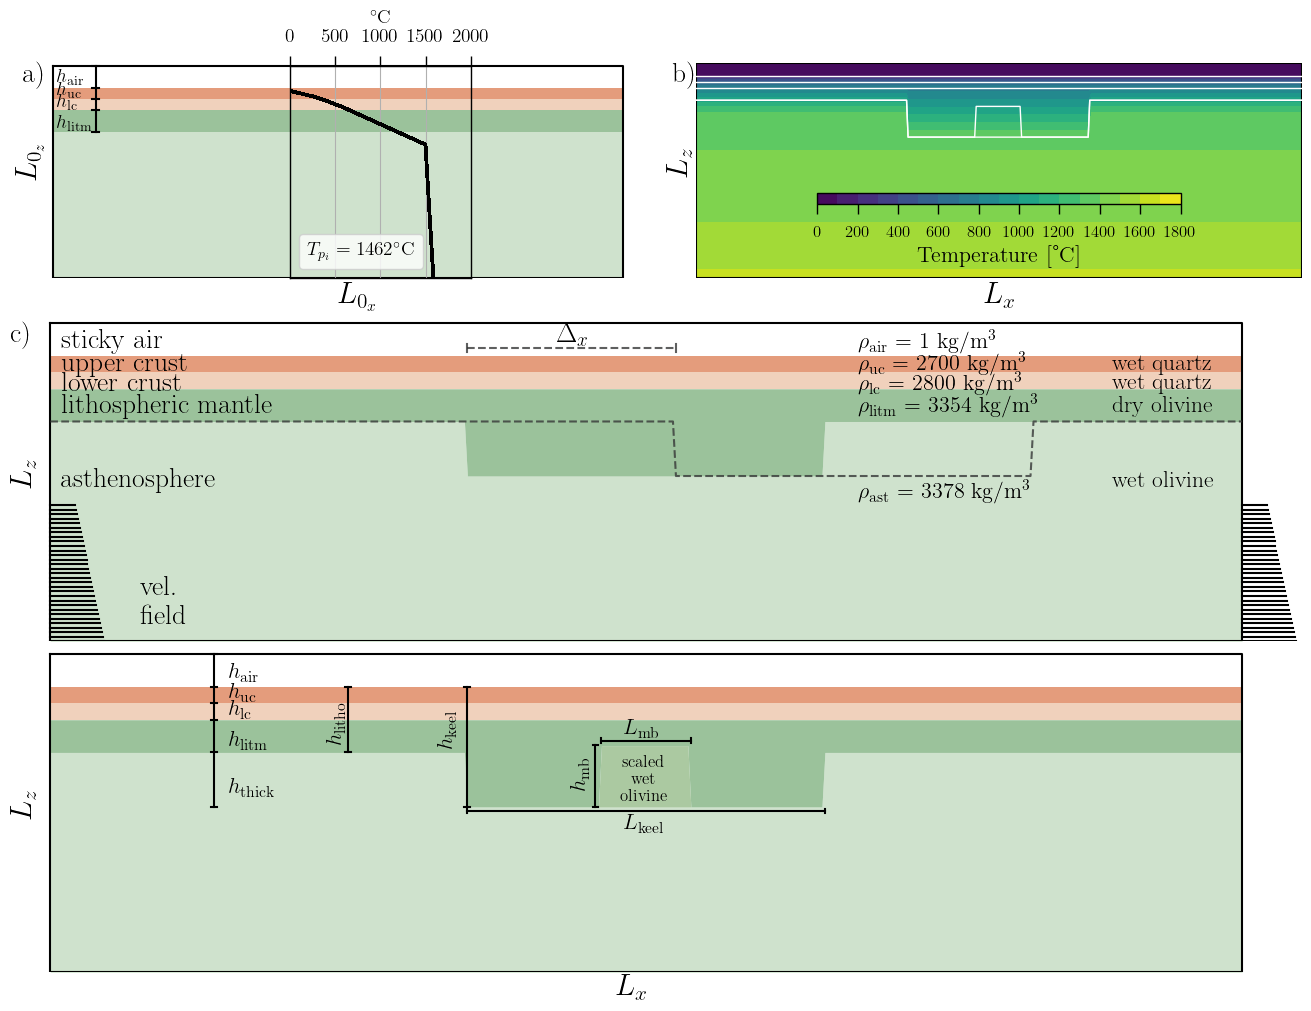

In [65]:
plt.close()
fig = plt.figure(figsize=(13,10), constrained_layout=True)
mosaic = """
         AABB
         CCCC
         DDDD
         """
axs = fig.subplot_mosaic(mosaic, gridspec_kw={'height_ratios':[0.3,0.45,0.45]})
fsize=16

#layers colour scheme
cr = 255.
color_uc = (228./cr,156./cr,124./cr)
color_lc = (240./cr,209./cr,188./cr)
color_lit = (155./cr,194./cr,155./cr)
color_ast = (207./cr,226./cr,205./cr)

##############################################################################
# Subplot a) Stability
##############################################################################
scale = 1.8
# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3*scale

thickness_lower_crust = 20.0e3*scale 

# thickness of upper crust (m)
thickness_upper_crust = 20.0e3*scale 

# total thickness of lithosphere (m)
thickness_litho = 80.0e3*scale #130 * 1.0e3

Lx_stab = 1600 * 1.0e3
Lz_stab = 700 * 1.0e3

Nx_stab = 161
Nz_stab = 71

x_stab = np.linspace(0, Lx_stab, Nx_stab)
z_stab = np.linspace(Lz_stab, 0, Nz_stab)
X_stab, Z_stab = np.meshgrid(x_stab, z_stab)
dz_stab = Lz_stab/ (Nz_stab - 1)

# Interfaces (bottom first)
interfaces_stab = {
    "litho_LAB": np.ones(Nx_stab) * (thickness_litho + thickness_sa), #lab horizontal
    "lower_crust": np.ones(Nx_stab) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx_stab) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx_stab) * (thickness_sa),
    }

axs['A'].text(-0.02, 0.95, 'a)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs['A'].transAxes)

axs['A'].set_xlim(0 - 50, Lx_stab/1000 + 50)
axs['A'].set_ylim(-Lz_stab/1000, 10)
axs['A'].axis('off')

#box domain contour
axs['A'].plot([0,0,Lx_stab/1000,Lx_stab/1000,0],[0,-Lz_stab/1000,-Lz_stab/1000,0,0],"k")

#paint layers
a1_stab = interfaces_stab["litho_LAB"]
a2_stab = a1_stab*0+700.0E3

axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_ast,ec="face",lw=0.0)

a2_stab = np.copy(a1_stab)
a1_stab = interfaces_stab["lower_crust"]
axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_lit,ec="face",lw=0.0)

a2_stab = np.copy(a1_stab)
a1_stab = interfaces_stab["upper_crust"]
axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_lc,ec="face",lw=0.0)

a2_stab = np.copy(a1_stab)
a1_stab= interfaces_stab["air"]
axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_uc,ec="face",lw=0.0)

xpos = 120
axs['A'].plot([xpos, xpos], [-0*scale,-120*scale], "k") #vertical bar
axs['A'].plot([xpos-10, xpos+10], [0*scale, 0*scale], "k") #upper horizontal bar
axs['A'].plot([xpos-10, xpos+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs['A'].plot([xpos-10, xpos+10], [-60*scale, -60*scale], "k") #base of upper crust
axs['A'].plot([xpos-10, xpos+10], [-80*scale, -80*scale], "k") #base of lower crust
axs['A'].plot([xpos-10, xpos+10], [-120*scale, -120*scale], "k") #base of litho
axs['A'].text(xpos-110, -30*scale, r"$h_{\mathrm{air}}$", fontsize=fsize-2)
axs['A'].text(xpos-110, -54*scale, r"$h_{\mathrm{uc}}$", fontsize=fsize-2)
axs['A'].text(xpos-110, -74*scale, r"$h_{\mathrm{lc}}$", fontsize=fsize-2)
axs['A'].text(xpos-110, -112*scale, r"$h_{\mathrm{litm}}$", fontsize=fsize-2)

#Lz and Lx
axs['A'].text(-105, -350, r"$L_{0_z}$",rotation=90, fontsize=fsize+6)
axs['A'].text(Lx_stab/2.0e3, -Lz_stab/1000-80, r"$L_{0_x}$", fontsize=fsize+6)

# ##############################################################################
# # Inset - Thermal profiles
# ##############################################################################
label_size=18
plt.rc('xtick', labelsize=label_size)
plt.rc('ytick', labelsize=label_size)

ax_aux = axs['A'].inset_axes([0.42,
                              0.001,
                              0.30,
                              0.985])

ax_aux.get_yaxis().set_visible(False)
ax_aux.set_xlabel('$^{\circ}$C', fontsize=label_size-4)
ax_aux.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, labelsize=label_size-4)
ax_aux.xaxis.set_label_position('top')
ax_aux.set_facecolor("none")
ax_aux.xaxis.grid('-k', alpha=1)

ax_aux.set_xlim([0,2000])
ax_aux.set_xticks([0, 500, 1000, 1500, 2000])
ax_aux.set_ylim(-Lz/1000, 10)

z = np.linspace(Lz, 0, Nz)*scale
cT = z>=40.0e3*scale

colors = ['xkcd:black']
lines = ['-']

for Tz, color, line in zip(Tzs, colors, lines):
    ax_aux.plot(Tz[cT], -(z[cT]/1000), line, color=color, linewidth=2, alpha=0.8)

axt = ax_aux.twinx()
axt1 = ax_aux.twinx()
axt.axis('off')
axt1.axis('off')

axt1.plot([-10, -10], '-', color=colors[0], label=r'$T_{p_i} = 1462^{\circ}$C')

axt1.legend(loc='lower left', labelcolor=colors[0], handlelength=0, handletextpad=0, fontsize=14)

##############################################################################
# Subplot b) Thermal profiles of keel scenarios
##############################################################################
scale = 1.0
# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3*scale

thickness_lower_crust = 20.0e3*scale 

# thickness of upper crust (m)
thickness_upper_crust = 20.0e3*scale 

# total thickness of lithosphere (m)
thickness_litho = 80.0e3*scale #130 * 1.0e3

interfaces = {
    "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
    "litho_HETERO": np.ones(Nx) * (thickness_litho + thickness_sa), #interface entre central e lateral -  interface 
    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx) * (thickness_sa),
    }

#Building craton
dx = Lx/(Nx-1)
# Lcraton = 600.0e3 #m
Lcraton = 1200.0e3 #m
#     Lcraton = 2000.0e3 #m
thickening = thickness_litho + 120.e3 #m
shift_craton = 0.0e3 #m

Ncraton = int(Lcraton//dx) #largura em indices

Nshift = int(shift_craton//dx)

interfaces['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

#Building mobile belt
interfaces['litho_HETERO'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening
Lmb = 300.0e3 #length of mobile belt
N_Lmb = int(Lmb//dx)
# thinning = 50.0e3
thinning = 100.0e3

interfaces['litho_HETERO'][Nx//2 - N_Lmb//2 + Nshift : Nx//2 + N_Lmb//2 + Nshift] = thickness_sa + thickening - thinning

axs['B'].text(-0.04, 0.95, 'b)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs['B'].transAxes)

axs['B'].set_xlim(0 - 50, Lx/1000 + 50)
axs['B'].set_ylim(-Lz/1000, 10)
axs['B'].axis('off')

#box domain contour
axs['B'].plot([0,0,Lx/1000,Lx/1000,0],[0,-Lz/1000,-Lz/1000,0,0],"k")

filename = 'input_temperature_0_keel.txt'
temper_0 = np.loadtxt(filename, skiprows=4, unpack=True)
temper_0 = np.reshape(temper_0, (Nz, Nx))

im = axs['B'].contourf(X/1.0e3, -Z/1.0e3, temper_0, cmap='viridis', levels=np.arange(0, np.max(temper_0) + 100, 100))
for interface in interfaces:
    if(interface != 'litho_HETERO'):
        axs['B'].plot(x/1.0e3, -interfaces[interface]/1.0e3/scale, '-', color='xkcd:white', lw=1.0)
    else:
        axs['B'].plot(x/1.0e3, -interfaces[interface]/1.0e3/scale, '-', color='xkcd:white', lw=1.0)

axins1 = inset_axes(axs['B'],
                    loc='lower center',
                    width="100%",  # respective to parent_bbox width
                    height="100%",  # respective to parent_bbox width
                    bbox_to_anchor=(0.20,#horizontal position respective to parent_bbox or "loc" position
                                    0.30,# vertical position
                                    0.6,# width
                                    0.05),# height
                    bbox_transform=axs['B'].transAxes
                    )

clb = fig.colorbar(im,
                    cax=axins1,
                    orientation='horizontal',
                    fraction=0.08,
                    pad=0.2)

fsize = 16
clb.set_label("Temperature [°C]", fontsize=fsize)
clb.ax.tick_params(labelsize=12)

axs['B'].set_xlim(0, Lx/1000)
axs['B'].set_ylim(-Lz/1000, 0)

fsize = 22
axs['B'].text(-200, -350, r"$L_z$",rotation=90, fontsize=fsize)
axs['B'].text(Lx/1000/2-100, -Lz/1000-80, r"$L_x$", fontsize=fsize)

##############################################################################
# Subplot c) interfaces,  Layers, veloc field
##############################################################################
ref_subplot = 'C'
scale = 1.8
# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3*scale

thickness_lower_crust = 20.0e3*scale 

# thickness of upper crust (m)
thickness_upper_crust = 20.0e3*scale 

# total thickness of lithosphere (m)
thickness_litho = 80.0e3*scale #130 * 1.0e3

interfaces = {
    "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx) * (thickness_sa),
    }

#Building craton
dx = Lx/(Nx-1)
# Lcraton = 600.0e3 #m
Lcraton = 1200.0e3 #m
#     Lcraton = 2000.0e3 #m
thickening = thickness_litho + 120.e3 #m
shift_craton = 0.0e3 #m

Ncraton = int(Lcraton//dx) #largura em indices

Nshift = int(shift_craton//dx)

interfaces['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

############################################################################################################################
#interfaces with shift craton of 700 km
############################################################################################################################

# Interfaces (bottom first)
interfaces_sc = {
    "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx) * (thickness_sa),
    }

#Building craton
dx = Lx/(Nx-1)
Lcraton = 1200.0e3 #m
thickening = thickness_litho + 120.e3 #m
shift_craton = 700.0e3 #m

Ncraton = int(Lcraton//dx) #largura em indices

Nshift = int(shift_craton//dx)

interfaces_sc['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening


axs['C'].text(-0.02, 0.95, 'c)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs['C'].transAxes)

axs['C'].set_xlim(0 - 50, Lx/1000 + 200)
axs['C'].set_ylim(-Lz/1000, 10)
axs['C'].axis('off')

#box domain contour
axs['C'].plot([0,0,Lx/1000,Lx/1000,0],[0,-Lz/1000,-Lz/1000,0,0],"k")

#paint layers
a1 = interfaces["litho_LAB"]
a2 = a1*0 + Lz
axs['C'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_ast,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["lower_crust"]
axs['C'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lit,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["upper_crust"]
axs['C'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lc,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["air"]
axs['C'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_uc,ec="face",lw=0.0)

axs['C'].plot(x/1.0e3, -interfaces_sc["litho_LAB"]/1.0e3, '--', color='xkcd:dark grey', alpha=0.8)

#Length of shift craton
xpos_sc = Lx/2.0e3 - Lcraton/2.0e3 #1850 km
axs['C'].plot([xpos_sc, xpos_sc],
              [(-30+5)*scale,(-30-5)*scale],
              color='xkcd:dark grey', alpha=0.8) #vertical bar

axs['C'].plot([xpos_sc, xpos_sc+shift_craton/1.0e3],
              [-30*scale,-30*scale],
              "--", color='xkcd:dark grey', alpha=0.8) #horizontal bar

axs['C'].plot([xpos_sc+shift_craton/1.0e3, xpos_sc+shift_craton/1.0e3],
              [(-30+5)*scale,(-30-5)*scale],
              color='xkcd:dark grey', alpha=0.8) #vertical bar

axs['C'].text(Lx/2.0e3-shift_craton/2.0e3+50, -22*scale, r"$\Delta_x$", fontsize=fsize-2, rotation=0)

# #thickness of cratonic region
# fsize=16
# xpos = Lx/2.0e3 - Lcraton/2.0e3
# axs['C'].plot([xpos-10, xpos+10], [-40*scale, -40*scale], "k") #upper horizontal bar
# axs['C'].plot([xpos, xpos], [-40*scale,-335], "k") #vertical bar
# axs['C'].plot([xpos-10, xpos+10], [-335, -335], "k") #lower horizontal bar
# axs['C'].text(xpos-100, -110*scale, r"$h_{\mathrm{keel}}$", fontsize=fsize, rotation=90)

# axs['C'].text(xpos-800, -30*scale, r"$h_{\mathrm{air}}$", fontsize=fsize)
# axs['C'].text(xpos-800, -54*scale, r"$h_{\mathrm{uc}}$", fontsize=fsize)
# axs['C'].text(xpos-800, -74*scale, r"$h_{\mathrm{lc}}$", fontsize=fsize)
# axs['C'].text(xpos-800, -112*scale, r"$h_{\mathrm{litm}}$", fontsize=fsize)
# axs['C'].text(xpos-800, -170*scale, r"$h_{\mathrm{thick}}$", fontsize=fsize)

# #thickness of lithosphere
# xpos2 = 1000    
# axs['C'].plot([xpos2-10, xpos2+10], [-40*scale, -40*scale], "k") #upper horizontal bar
# axs['C'].plot([xpos2, xpos2], [-40*scale,-120*scale], "k") #vertical bar
# axs['C'].plot([xpos2-10, xpos2+10], [-120*scale, -120*scale], "k") #lower horizontal bar
# axs['C'].text(xpos2-75, -105*scale, r"$h_{\mathrm{litho}}$", fontsize=fsize, rotation=90)


# #thickness of non-cratonic region
# xpos3 = 550
# axs['C'].plot([xpos3, xpos3], [-0*scale,-335], "k") #vertical bar
# axs['C'].plot([xpos3-10, xpos3+10], [0*scale, 0*scale], "k") #upper horizontal bar
# axs['C'].plot([xpos3-10, xpos3+10], [-40*scale, -40*scale], "k") #upper horizontal bar
# axs['C'].plot([xpos3-10, xpos3+10], [-60*scale, -60*scale], "k") #base of upper crust
# axs['C'].plot([xpos3-10, xpos3+10], [-80*scale, -80*scale], "k") #base of lower crust
# axs['C'].plot([xpos3-10, xpos3+10], [-120*scale, -120*scale], "k") #base of litho
# axs['C'].plot([xpos3-10, xpos3+10], [-335, -335], "k") #lower horizontal bar

# #Length of Cratonic Region
# xpos4 = Lx/2.0e3 - Lcraton/2.0e3 #1850 km
# axs['C'].plot([xpos4, xpos4], [(-345+5),(-345-5)], "k") #vertical bar
# axs['C'].plot([xpos4, xpos4+Lcraton/1.0e3], [-345,-345], "k") #horizontal bar
# axs['C'].plot([xpos4+Lcraton/1.0e3, xpos4+Lcraton/1.0e3], [(-345+5),(-345-5)], "k") #vertical bar

# axs['C'].text(Lx/2.0e3-75, -385, r"$L_{\mathrm{keel}}$", fontsize=fsize, rotation=0)


#Naming layers
fsize=20
axs['C'].text(0.02, 0.93, "sticky air", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['C'].transAxes)
axs['C'].text(0.02, 0.86, "upper crust", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['C'].transAxes)
axs['C'].text(0.02, 0.80, "lower crust", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['C'].transAxes)
axs['C'].text(0.02, 0.73, "lithospheric mantle", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['C'].transAxes)
axs['C'].text(0.02, 0.50, "asthenosphere", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['C'].transAxes)

#Rheology
fsize=17
axs['C'].text(0.85, 0.86, 'wet quartz', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['C'].transAxes)
axs['C'].text(0.85, 0.80, 'wet quartz', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['C'].transAxes)
axs['C'].text(0.85, 0.73, 'dry olivine', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['C'].transAxes)
axs['C'].text(0.85, 0.50, 'wet olivine', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['C'].transAxes)

#Layers densities
fsize=16
axs['C'].text(0.65, 0.93, r'$\rho_{\mathrm{air}}$ = 1 kg/m$^3$', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['C'].transAxes)
axs['C'].text(0.65, 0.86, r'$\rho_{\mathrm{uc}}$ = 2700 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['C'].transAxes)
axs['C'].text(0.65, 0.80, r'$\rho_{\mathrm{lc}}$ = 2800 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['C'].transAxes)
axs['C'].text(0.65, 0.73, r'$\rho_{\mathrm{litm}}$ = 3354 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['C'].transAxes)
axs['C'].text(0.65, 0.465, r'$\rho_{\mathrm{ast}}$ = 3378 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['C'].transAxes)



#Lz and Lx
fsize=22
axs['C'].text(-135, -350, r"$L_z$",rotation=90, fontsize=fsize)
# axs['C'].text(Lx/1000/2-100, -Lz/1000-50, r"$L_x$", fontsize=fsize)

axs['C'].text(300,-660,"vel.\nfield",fontsize=fsize-2)

z = np.linspace(Lz, 0, Nz)
scale_veloc = 15000*365.*24.*3600.
for i in range(0,np.size(z)-40,1):
    if VX[i,0]!=0.0:
        axs['C'].plot([scale_veloc*VX[i, 0],0], [-z[i]/1000,-z[i]/1000],"k")

for i in range(0,np.size(z)-40,1):
    axs['C'].plot([scale_veloc*VX[i, -1]+Lx/1000,Lx/1000], [-z[i]/1000,-z[i]/1000],"k")

############################################################################################################
# subplot d) Scenarios with mobile belt
############################################################################################################
scale = 1.8
# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3*scale

thickness_lower_crust = 20.0e3*scale 

# thickness of upper crust (m)
thickness_upper_crust = 20.0e3*scale 

# total thickness of lithosphere (m)
thickness_litho = 80.0e3*scale #130 * 1.0e3

interfaces = {
    "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
    "litho_HETERO": np.ones(Nx) * (thickness_litho + thickness_sa), #interface entre central e lateral -  interface 
    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx) * (thickness_sa),
    }

#Building craton
dx = Lx/(Nx-1)
# Lcraton = 600.0e3 #m
Lcraton = 1200.0e3 #m
#     Lcraton = 2000.0e3 #m
thickening = thickness_litho + 120.e3 #m
shift_craton = 0.0e3 #m

Ncraton = int(Lcraton//dx) #largura em indices

Nshift = int(shift_craton//dx)

interfaces['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

#Building mobile belt
interfaces['litho_HETERO'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening
Lmb = 300.0e3 #length of mobile belt
N_Lmb = int(Lmb//dx)
# thinning = 50.0e3
# thinning = 100.0e3
thinning = 135.0e3

interfaces['litho_HETERO'][Nx//2 - N_Lmb//2 + Nshift : Nx//2 + N_Lmb//2 + Nshift] = thickness_sa + thickening - thinning


# axs['D'].text(-0.02, 0.95, 'd)', color='k', fontsize=20,
#         horizontalalignment='left', verticalalignment='center',
#         transform=axs['D'].transAxes)

axs['D'].set_xlim(0 - 50, Lx/1000 + 200)
axs['D'].set_ylim(-Lz/1000, 10)
axs['D'].axis('off')

#box domain contour
axs['D'].plot([0,0,Lx/1000,Lx/1000,0],[0,-Lz/1000,-Lz/1000,0,0],"k")

#paint layers
a1 = interfaces["litho_LAB"]
a2 = a1*0 + Lz
axs['D'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_ast,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["litho_HETERO"]
axs['D'].fill_between(x/1000,-a1/1000,-a2/1000,fc='xkcd:dull green',ec="face",lw=0.0, alpha=0.6) #grey green

a2 = np.copy(a1)
a1 = interfaces["lower_crust"]
axs['D'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lit,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["upper_crust"]
axs['D'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lc,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["air"]
axs['D'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_uc,ec="face",lw=0.0)

#thickness of cratonic region
fsize=16
xpos = Lx/2.0e3 - Lcraton/2.0e3
axs['D'].plot([xpos-10, xpos+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs['D'].plot([xpos, xpos], [-40*scale,-335], "k") #vertical bar
axs['D'].plot([xpos-10, xpos+10], [-335, -335], "k") #lower horizontal bar
axs['D'].text(xpos-100, -110*scale, r"$h_{\mathrm{keel}}$", fontsize=fsize, rotation=90)

axs['D'].text(xpos-800, -30*scale, r"$h_{\mathrm{air}}$", fontsize=fsize)
axs['D'].text(xpos-800, -54*scale, r"$h_{\mathrm{uc}}$", fontsize=fsize)
axs['D'].text(xpos-800, -74*scale, r"$h_{\mathrm{lc}}$", fontsize=fsize)
axs['D'].text(xpos-800, -112*scale, r"$h_{\mathrm{litm}}$", fontsize=fsize)
axs['D'].text(xpos-800, -170*scale, r"$h_{\mathrm{thick}}$", fontsize=fsize)

#thickness of lithosphere
xpos2 = 1000    
axs['D'].plot([xpos2-10, xpos2+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs['D'].plot([xpos2, xpos2], [-40*scale,-120*scale], "k") #vertical bar
axs['D'].plot([xpos2-10, xpos2+10], [-120*scale, -120*scale], "k") #lower horizontal bar
axs['D'].text(xpos2-75, -105*scale, r"$h_{\mathrm{litho}}$", fontsize=fsize, rotation=90)


#thickness of non-cratonic region
xpos3 = 550
axs['D'].plot([xpos3, xpos3], [-0*scale,-335], "k") #vertical bar
axs['D'].plot([xpos3-10, xpos3+10], [0*scale, 0*scale], "k") #upper horizontal bar
axs['D'].plot([xpos3-10, xpos3+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs['D'].plot([xpos3-10, xpos3+10], [-60*scale, -60*scale], "k") #base of upper crust
axs['D'].plot([xpos3-10, xpos3+10], [-80*scale, -80*scale], "k") #base of lower crust
axs['D'].plot([xpos3-10, xpos3+10], [-120*scale, -120*scale], "k") #base of litho
axs['D'].plot([xpos3-10, xpos3+10], [-335, -335], "k") #lower horizontal bar

#Length of Cratonic Region
xpos4 = Lx/2.0e3 - Lcraton/2.0e3 #1850 km
axs['D'].plot([xpos4, xpos4], [(-345+5),(-345-5)], "k") #vertical bar
axs['D'].plot([xpos4, xpos4+Lcraton/1.0e3], [-345,-345], "k") #horizontal bar
axs['D'].plot([xpos4+Lcraton/1.0e3, xpos4+Lcraton/1.0e3], [(-345+5),(-345-5)], "k") #vertical bar

axs['D'].text(Lx/2.0e3-75, -385, r"$L_{\mathrm{keel}}$", fontsize=fsize, rotation=0)

#Mobile Belt
fsize=16
xpos4 = Lx/2.0e3 - Lmb/2.0e3 #1850 km
axs['D'].plot([xpos4-10- 20, xpos4+10- 20], [-200, -200], "k") #lower horizontal bar
axs['D'].plot([xpos4- 20, xpos4- 20], [-200,-335], "k") #vertical bar
axs['D'].plot([xpos4-10- 20, xpos4+10- 20], [-335, -335], "k") #lower horizontal bar
axs['D'].text(xpos4-85- 20, -290, r"$h_{\mathrm{mb}}$", fontsize=fsize, rotation=90)

axs['D'].plot([xpos4, xpos4], [(-190+5),(-190-5)], "k") #vertical bar
axs['D'].plot([xpos4, xpos4+Lmb/1.0e3], [-190,-190], "k") #horizontal bar
axs['D'].plot([xpos4+Lmb/1.0e3, xpos4+Lmb/1.0e3], [-190+5,-190-5], "k") #vertical bar
axs['D'].text(Lx/2.0e3-75, -175, r"$L_{\mathrm{mb}}$", fontsize=fsize, rotation=0)


# #Naming layers
# fsize=20
# axs['D'].text(0.02, 0.93, "sticky air", fontsize=fsize,
#               horizontalalignment='left', verticalalignment='center',
#               transform=axs['D'].transAxes)
# axs['D'].text(0.02, 0.86, "upper crust", fontsize=fsize,
#               horizontalalignment='left', verticalalignment='center',
#               transform=axs['D'].transAxes)
# axs['D'].text(0.02, 0.80, "lower crust", fontsize=fsize,
#               horizontalalignment='left', verticalalignment='center',
#               transform=axs['D'].transAxes)
# axs['D'].text(0.02, 0.73, "lithospheric mantle", fontsize=fsize,
#               horizontalalignment='left', verticalalignment='center',
#               transform=axs['D'].transAxes)
# axs['D'].text(0.02, 0.50, "asthenosphere", fontsize=fsize,
#               horizontalalignment='left', verticalalignment='center',
#               transform=axs['D'].transAxes)

# #Rheology
# fsize=17
# axs['D'].text(0.85, 0.86, 'wet quartz', color='k', fontsize=fsize,
#               horizontalalignment='left', verticalalignment='center',
#               transform=axs['D'].transAxes)
# axs['D'].text(0.85, 0.80, 'wet quartz', color='k', fontsize=fsize,
#               horizontalalignment='left', verticalalignment='center',
#               transform=axs['D'].transAxes)
# axs['D'].text(0.85, 0.73, 'dry olivine', color='k', fontsize=fsize,
#               horizontalalignment='left', verticalalignment='center',
#               transform=axs['D'].transAxes)
# axs['D'].text(0.85, 0.50, 'wet olivine', color='k', fontsize=fsize,
#               horizontalalignment='left', verticalalignment='center',
#               transform=axs['D'].transAxes)
# fsize=12
# axs['D'].text(0.48, 0.60, 'scaled\nwet\nolivine', color='k', fontsize=fsize,
#               horizontalalignment='center', verticalalignment='center',
#               transform=axs['D'].transAxes)

# #Layers densities
# fsize=16
# axs['D'].text(0.65, 0.93, r'$\rho_{\mathrm{air}}$ = 1 kg/m$^3$', fontsize=fsize,
#               horizontalalignment='left', verticalalignment='center',
#               transform=axs['D'].transAxes)
# axs['D'].text(0.65, 0.86, r'$\rho_{\mathrm{uc}}$ = 2700 kg/m$^3$', color='k', fontsize=fsize,
#               horizontalalignment='left', verticalalignment='center',
#               transform=axs['D'].transAxes)
# axs['D'].text(0.65, 0.80, r'$\rho_{\mathrm{lc}}$ = 2800 kg/m$^3$', color='k', fontsize=fsize,
#               horizontalalignment='left', verticalalignment='center',
#               transform=axs['D'].transAxes)
# axs['D'].text(0.65, 0.73, r'$\rho_{\mathrm{litm}}$ = 3354 kg/m$^3$', color='k', fontsize=fsize,
#               horizontalalignment='left', verticalalignment='center',
#               transform=axs['D'].transAxes)
# axs['D'].text(0.65, 0.465, r'$\rho_{\mathrm{ast}}$ = 3378 kg/m$^3$', color='k', fontsize=fsize,
#               horizontalalignment='left', verticalalignment='center',
#               transform=axs['D'].transAxes)

fsize=12
axs['D'].text(0.48, 0.60, 'scaled\nwet\nolivine', color='k', fontsize=fsize,
              horizontalalignment='center', verticalalignment='center',
              transform=axs['D'].transAxes)

#Lz and Lx
fsize=22
axs['D'].text(-135, -350, r"$L_z$",rotation=90, fontsize=fsize)
axs['D'].text(Lx/1000/2-100, -Lz/1000-50, r"$L_x$", fontsize=fsize)

# Saving figure
fig.savefig('figures/NumSetup_Keel.pdf', dpi=400, bbox_inches='tight')
fig.savefig('figures/NumSetup_Keel.png', dpi=400, bbox_inches='tight')

# Num Setup Poster

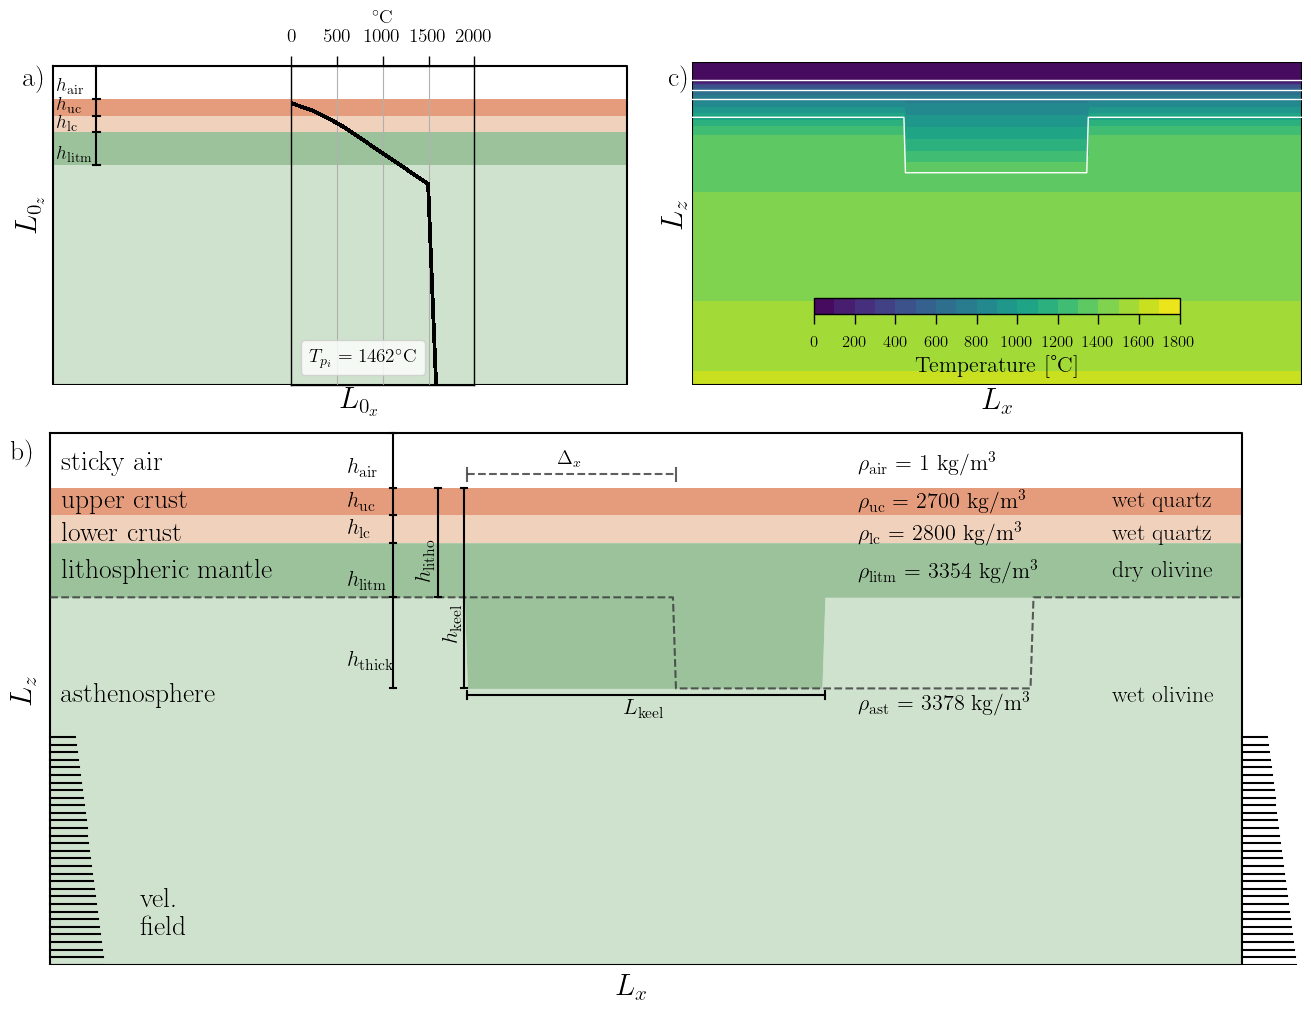

In [7]:
plt.close()
fig = plt.figure(figsize=(13,10), constrained_layout=True)
mosaic = """
         AACC
         BBBB
         """
axs = fig.subplot_mosaic(mosaic, gridspec_kw={'height_ratios':[0.3,0.5]})
fsize=16

#layers colour scheme
cr = 255.
color_uc = (228./cr,156./cr,124./cr)
color_lc = (240./cr,209./cr,188./cr)
color_lit = (155./cr,194./cr,155./cr)
color_ast = (207./cr,226./cr,205./cr)

##############################################################################
# Subplot a) Stability
##############################################################################
scale = 1.8
# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3*scale

thickness_lower_crust = 20.0e3*scale 

# thickness of upper crust (m)
thickness_upper_crust = 20.0e3*scale 

# total thickness of lithosphere (m)
thickness_litho = 80.0e3*scale #130 * 1.0e3

Lx_stab = 1600 * 1.0e3
Lz_stab = 700 * 1.0e3

Nx_stab = 161
Nz_stab = 71

x_stab = np.linspace(0, Lx_stab, Nx_stab)
z_stab = np.linspace(Lz_stab, 0, Nz_stab)
X_stab, Z_stab = np.meshgrid(x_stab, z_stab)
dz_stab = Lz_stab/ (Nz_stab - 1)

# Interfaces (bottom first)
interfaces_stab = {
    "litho_LAB": np.ones(Nx_stab) * (thickness_litho + thickness_sa), #lab horizontal
    "lower_crust": np.ones(Nx_stab) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx_stab) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx_stab) * (thickness_sa),
    }

axs['A'].text(-0.02, 0.95, 'a)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs['A'].transAxes)

axs['A'].set_xlim(0 - 50, Lx_stab/1000 + 50)
axs['A'].set_ylim(-Lz_stab/1000, 10)
axs['A'].axis('off')

#box domain contour
axs['A'].plot([0,0,Lx_stab/1000,Lx_stab/1000,0],[0,-Lz_stab/1000,-Lz_stab/1000,0,0],"k")

#paint layers
a1_stab = interfaces_stab["litho_LAB"]
a2_stab = a1_stab*0+700.0E3

axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_ast,ec="face",lw=0.0)

a2_stab = np.copy(a1_stab)
a1_stab = interfaces_stab["lower_crust"]
axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_lit,ec="face",lw=0.0)

a2_stab = np.copy(a1_stab)
a1_stab = interfaces_stab["upper_crust"]
axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_lc,ec="face",lw=0.0)

a2_stab = np.copy(a1_stab)
a1_stab= interfaces_stab["air"]
axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_uc,ec="face",lw=0.0)

xpos = 120
axs['A'].plot([xpos, xpos], [-0*scale,-120*scale], "k") #vertical bar
axs['A'].plot([xpos-10, xpos+10], [0*scale, 0*scale], "k") #upper horizontal bar
axs['A'].plot([xpos-10, xpos+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs['A'].plot([xpos-10, xpos+10], [-60*scale, -60*scale], "k") #base of upper crust
axs['A'].plot([xpos-10, xpos+10], [-80*scale, -80*scale], "k") #base of lower crust
axs['A'].plot([xpos-10, xpos+10], [-120*scale, -120*scale], "k") #base of litho
axs['A'].text(xpos-110, -30*scale, r"$h_{\mathrm{air}}$", fontsize=fsize-2)
axs['A'].text(xpos-110, -54*scale, r"$h_{\mathrm{uc}}$", fontsize=fsize-2)
axs['A'].text(xpos-110, -74*scale, r"$h_{\mathrm{lc}}$", fontsize=fsize-2)
axs['A'].text(xpos-110, -112*scale, r"$h_{\mathrm{litm}}$", fontsize=fsize-2)

#Lz and Lx
axs['A'].text(-105, -350, r"$L_{0_z}$",rotation=90, fontsize=fsize+6)
axs['A'].text(Lx_stab/2.0e3, -Lz_stab/1000-50, r"$L_{0_x}$", fontsize=fsize+6)

# ##############################################################################
# # Inset - Thermal profiles
# ##############################################################################
label_size=18
plt.rc('xtick', labelsize=label_size)
plt.rc('ytick', labelsize=label_size)

ax_aux = axs['A'].inset_axes([0.42,
                              0.001,
                              0.30,
                              0.985])

ax_aux.get_yaxis().set_visible(False)
ax_aux.set_xlabel('$^{\circ}$C', fontsize=label_size-4)
ax_aux.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, labelsize=label_size-4)
ax_aux.xaxis.set_label_position('top')
ax_aux.set_facecolor("none")
ax_aux.xaxis.grid('-k', alpha=1)

ax_aux.set_xlim([0,2000])
ax_aux.set_xticks([0, 500, 1000, 1500, 2000])
ax_aux.set_ylim(-Lz/1000, 10)

z = np.linspace(Lz, 0, Nz)*scale
cT = z>=40.0e3*scale

colors = ['xkcd:black']
lines = ['-']

for Tz, color, line in zip(Tzs, colors, lines):
    ax_aux.plot(Tz[cT], -(z[cT]/1000), line, color=color, linewidth=2, alpha=0.8)

axt = ax_aux.twinx()
axt1 = ax_aux.twinx()
axt.axis('off')
axt1.axis('off')

axt1.plot([-10, -10], '-', color=colors[0], label=r'$T_{p_i} = 1462^{\circ}$C')

axt1.legend(loc='lower left', labelcolor=colors[0], handlelength=0, handletextpad=0, fontsize=14)

##############################################################################
# Subplot b) interfaces,  Layers, veloc field
##############################################################################

scale = 1.8
# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3*scale

thickness_lower_crust = 20.0e3*scale 

# thickness of upper crust (m)
thickness_upper_crust = 20.0e3*scale 

# total thickness of lithosphere (m)
thickness_litho = 80.0e3*scale #130 * 1.0e3

interfaces = {
    "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx) * (thickness_sa),
    }

#Building craton
dx = Lx/(Nx-1)
# Lcraton = 600.0e3 #m
Lcraton = 1200.0e3 #m
#     Lcraton = 2000.0e3 #m
thickening = thickness_litho + 120.e3 #m
shift_craton = 0.0e3 #m

Ncraton = int(Lcraton//dx) #largura em indices

Nshift = int(shift_craton//dx)

interfaces['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

############################################################################################################################
#interfaces with shift craton of 700 km
############################################################################################################################

# Interfaces (bottom first)
interfaces_sc = {
    "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx) * (thickness_sa),
    }

#Building craton
dx = Lx/(Nx-1)
Lcraton = 1200.0e3 #m
thickening = thickness_litho + 120.e3 #m
shift_craton = 700.0e3 #m

Ncraton = int(Lcraton//dx) #largura em indices

Nshift = int(shift_craton//dx)

interfaces_sc['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

# axs['B'].text(-120, 12, r"a)", size=20)
axs['B'].text(-0.02, 0.95, 'b)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs['B'].transAxes)

axs['B'].set_xlim(0 - 50, Lx/1000 + 200)
axs['B'].set_ylim(-Lz/1000, 10)
axs['B'].axis('off')

#box domain contour
axs['B'].plot([0,0,Lx/1000,Lx/1000,0],[0,-Lz/1000,-Lz/1000,0,0],"k")

#paint layers
a1 = interfaces["litho_LAB"]
a2 = a1*0 + Lz
axs['B'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_ast,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["lower_crust"]
axs['B'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lit,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["upper_crust"]
axs['B'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lc,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["air"]
axs['B'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_uc,ec="face",lw=0.0)

axs['B'].plot(x/1.0e3, -interfaces_sc["litho_LAB"]/1.0e3, '--', color='xkcd:dark grey', alpha=0.8)

#Length of shift craton
xpos_sc = Lx/2.0e3 - Lcraton/2.0e3 #1850 km
axs['B'].plot([xpos_sc, xpos_sc],
              [(-30+5)*scale,(-30-5)*scale],
              color='xkcd:dark grey', alpha=0.8) #vertical bar

axs['B'].plot([xpos_sc, xpos_sc+shift_craton/1.0e3],
              [-30*scale,-30*scale],
              "--", color='xkcd:dark grey', alpha=0.8) #horizontal bar

axs['B'].plot([xpos_sc+shift_craton/1.0e3, xpos_sc+shift_craton/1.0e3],
              [(-30+5)*scale,(-30-5)*scale],
              color='xkcd:dark grey', alpha=0.8) #vertical bar

axs['B'].text(Lx/2.0e3-shift_craton/2.0e3+50, -22*scale, r"$\Delta_x$", fontsize=fsize-2, rotation=0)

#Naming layers
fsize=20
axs['B'].text(0.02, 0.93, "sticky air", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.02, 0.86, "upper crust", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.02, 0.80, "lower crust", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.02, 0.73, "lithospheric mantle", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.02, 0.50, "asthenosphere", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)

#Rheology
fsize=17
axs['B'].text(0.85, 0.86, 'wet quartz', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.85, 0.80, 'wet quartz', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.85, 0.73, 'dry olivine', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.85, 0.50, 'wet olivine', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)

#Layers densities
fsize=16
axs['B'].text(0.65, 0.93, r'$\rho_{\mathrm{air}}$ = 1 kg/m$^3$', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.65, 0.86, r'$\rho_{\mathrm{uc}}$ = 2700 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.65, 0.80, r'$\rho_{\mathrm{lc}}$ = 2800 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.65, 0.73, r'$\rho_{\mathrm{litm}}$ = 3354 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.65, 0.485, r'$\rho_{\mathrm{ast}}$ = 3378 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)


#thickness of cratonic region
fsize=16
xpos = 1390
axs['B'].plot([xpos-10, xpos+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs['B'].plot([xpos, xpos], [-40*scale,-335], "k") #vertical bar
axs['B'].plot([xpos-10, xpos+10], [-335, -335], "k") #lower horizontal bar
axs['B'].text(xpos-75, -150*scale, r"$h_{\mathrm{keel}}$", fontsize=fsize, rotation=90)

#thickness of non-cratonic region
xpos2 = 1300    
axs['B'].plot([xpos2-10, xpos2+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs['B'].plot([xpos2, xpos2], [-40*scale,-120*scale], "k") #vertical bar
axs['B'].plot([xpos2-10, xpos2+10], [-120*scale, -120*scale], "k") #lower horizontal bar
axs['B'].text(xpos2-75, -105*scale, r"$h_{\mathrm{litho}}$", fontsize=fsize, rotation=90)

#thickness of non-cratonic region
xpos3 = 1150
axs['B'].plot([xpos3, xpos3], [-0*scale,-335], "k") #vertical bar
axs['B'].plot([xpos3-10, xpos3+10], [0*scale, 0*scale], "k") #upper horizontal bar
axs['B'].plot([xpos3-10, xpos3+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs['B'].plot([xpos3-10, xpos3+10], [-60*scale, -60*scale], "k") #base of upper crust
axs['B'].plot([xpos3-10, xpos3+10], [-80*scale, -80*scale], "k") #base of lower crust
axs['B'].plot([xpos3-10, xpos3+10], [-120*scale, -120*scale], "k") #base of litho
axs['B'].plot([xpos3-10, xpos3+10], [-335, -335], "k") #lower horizontal bar

#Length of Cratonic Region
xpos4 = Lx/2.0e3 - Lcraton/2.0e3 #1850 km
axs['B'].plot([xpos4, xpos4], [(-345+5),(-345-5)], "k") #vertical bar
axs['B'].plot([xpos4, xpos4+Lcraton/1.0e3], [-345,-345], "k") #horizontal bar
axs['B'].plot([xpos4+Lcraton/1.0e3, xpos4+Lcraton/1.0e3], [(-345+5),(-345-5)], "k") #vertical bar
axs['B'].text(Lx/2.0e3-75, -370, r"$L_{\mathrm{keel}}$", fontsize=fsize, rotation=0)

axs['B'].text(xpos-390, -30*scale, r"$h_{\mathrm{air}}$", fontsize=fsize)
axs['B'].text(xpos-390, -54*scale, r"$h_{\mathrm{uc}}$", fontsize=fsize)
axs['B'].text(xpos-390, -74*scale, r"$h_{\mathrm{lc}}$", fontsize=fsize)
axs['B'].text(xpos-390, -112*scale, r"$h_{\mathrm{litm}}$", fontsize=fsize)
axs['B'].text(xpos-390, -170*scale, r"$h_{\mathrm{thick}}$", fontsize=fsize)

#Lz and Lx
fsize=22
axs['B'].text(-135, -350, r"$L_z$",rotation=90, fontsize=fsize)
axs['B'].text(Lx/1000/2-100, -Lz/1000-40, r"$L_x$", fontsize=fsize)

axs['B'].text(300,-660,"vel.\nfield",fontsize=fsize-2)

z = np.linspace(Lz, 0, Nz)
scale_veloc = 15000*365.*24.*3600.
for i in range(0,np.size(z)-40,1):
    if VX[i,0]!=0.0:
        axs['B'].plot([scale_veloc*VX[i, 0],0], [-z[i]/1000,-z[i]/1000],"k")

for i in range(0,np.size(z)-40,1):
    axs['B'].plot([scale_veloc*VX[i, -1]+Lx/1000,Lx/1000], [-z[i]/1000,-z[i]/1000],"k")

##############################################################################
# Subplot c) Thermal profiles of keel scenarios
##############################################################################
scale = 1.0
# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3*scale

thickness_lower_crust = 20.0e3*scale 

# thickness of upper crust (m)
thickness_upper_crust = 20.0e3*scale 

# total thickness of lithosphere (m)
thickness_litho = 80.0e3*scale #130 * 1.0e3

interfaces = {
    "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx) * (thickness_sa),
    }

#Building craton
dx = Lx/(Nx-1)
# Lcraton = 600.0e3 #m
Lcraton = 1200.0e3 #m
#     Lcraton = 2000.0e3 #m
thickening = thickness_litho + 120.e3 #m
shift_craton = 0.0e3 #m

Ncraton = int(Lcraton//dx) #largura em indices

Nshift = int(shift_craton//dx)

interfaces['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

axs['C'].text(-0.04, 0.95, 'c)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs['C'].transAxes)

axs['C'].set_xlim(0 - 50, Lx/1000 + 50)
axs['C'].set_ylim(-Lz/1000, 10)
axs['C'].axis('off')

#box domain contour
axs['C'].plot([0,0,Lx/1000,Lx/1000,0],[0,-Lz/1000,-Lz/1000,0,0],"k")

filename = 'input_temperature_0_keel.txt'
temper_0 = np.loadtxt(filename, skiprows=4, unpack=True)
temper_0 = np.reshape(temper_0, (Nz, Nx))

im = axs['C'].contourf(X/1.0e3, -Z/1.0e3, temper_0, cmap='viridis', levels=np.arange(0, np.max(temper_0) + 100, 100))
for interface in interfaces:
    axs['C'].plot(x/1.0e3, -interfaces[interface]/1.0e3/scale, '-', color='xkcd:white', lw=1.0)

axins1 = inset_axes(axs['C'],
                    loc='lower center',
                    width="100%",  # respective to parent_bbox width
                    height="100%",  # respective to parent_bbox width
                    bbox_to_anchor=(0.20,#horizontal position respective to parent_bbox or "loc" position
                                    0.19,# vertical position
                                    0.6,# width
                                    0.05),# height
                    bbox_transform=axs['C'].transAxes
                    )

clb = fig.colorbar(im,
                    cax=axins1,
                    orientation='horizontal',
                    fraction=0.08,
                    pad=0.2)

fsize = 16
clb.set_label("Temperature [°C]", fontsize=fsize)
clb.ax.tick_params(labelsize=12)

axs['C'].set_xlim(0, Lx/1000)
axs['C'].set_ylim(-Lz/1000, 0)

fsize = 22
axs['C'].text(-200, -350, r"$L_z$",rotation=90, fontsize=fsize)
axs['C'].text(Lx/1000/2-100, -Lz/1000-50, r"$L_x$", fontsize=fsize)

# Saving figure
fig.savefig('figures/POSTER_NumSetup_Keel.pdf', dpi=400, bbox_inches='tight')
fig.savefig('figures/POSTER_NumSetup_Keel.png', dpi=400, bbox_inches='tight')

# Num Setup Article

# Article working


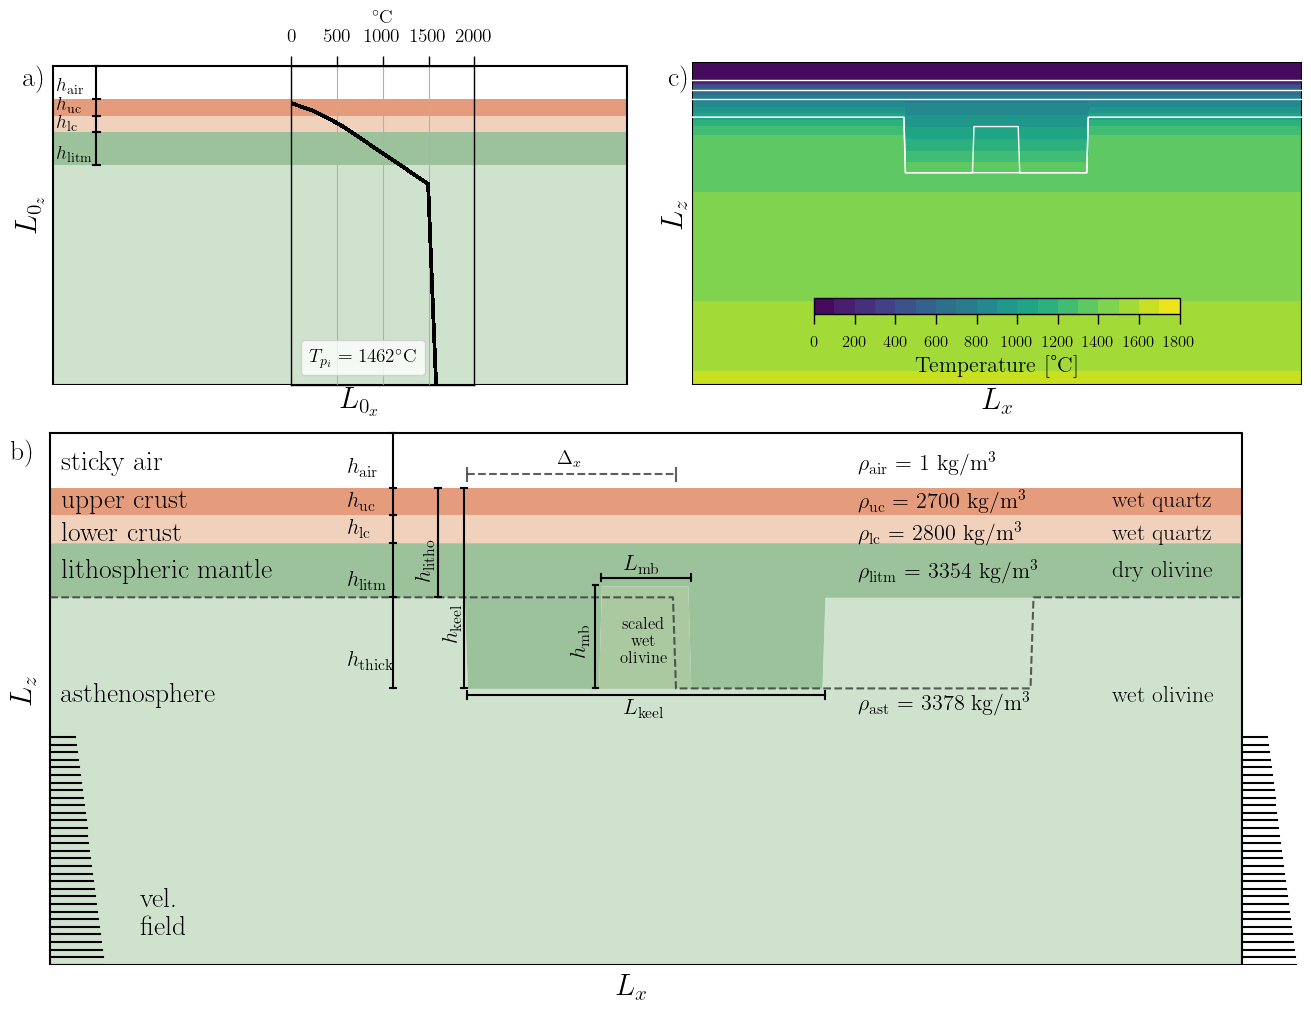

In [14]:
plt.close()
fig = plt.figure(figsize=(13,10), constrained_layout=True)
mosaic = """
         AACC
         BBBB
         """
axs = fig.subplot_mosaic(mosaic, gridspec_kw={'height_ratios':[0.3,0.5]})
fsize=16

#layers colour scheme
cr = 255.
color_uc = (228./cr,156./cr,124./cr)
color_lc = (240./cr,209./cr,188./cr)
color_lit = (155./cr,194./cr,155./cr)
color_ast = (207./cr,226./cr,205./cr)

##############################################################################
# Subplot a) Stability
##############################################################################
scale = 1.8
# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3*scale

thickness_lower_crust = 20.0e3*scale 

# thickness of upper crust (m)
thickness_upper_crust = 20.0e3*scale 

# total thickness of lithosphere (m)
thickness_litho = 80.0e3*scale #130 * 1.0e3

Lx_stab = 1600 * 1.0e3
Lz_stab = 700 * 1.0e3

Nx_stab = 161
Nz_stab = 71

x_stab = np.linspace(0, Lx_stab, Nx_stab)
z_stab = np.linspace(Lz_stab, 0, Nz_stab)
X_stab, Z_stab = np.meshgrid(x_stab, z_stab)
dz_stab = Lz_stab/ (Nz_stab - 1)

# Interfaces (bottom first)
interfaces_stab = {
    "litho_LAB": np.ones(Nx_stab) * (thickness_litho + thickness_sa), #lab horizontal
    "lower_crust": np.ones(Nx_stab) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx_stab) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx_stab) * (thickness_sa),
    }

axs['A'].text(-0.02, 0.95, 'a)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs['A'].transAxes)

axs['A'].set_xlim(0 - 50, Lx_stab/1000 + 50)
axs['A'].set_ylim(-Lz_stab/1000, 10)
axs['A'].axis('off')

#box domain contour
axs['A'].plot([0,0,Lx_stab/1000,Lx_stab/1000,0],[0,-Lz_stab/1000,-Lz_stab/1000,0,0],"k")

#paint layers
a1_stab = interfaces_stab["litho_LAB"]
a2_stab = a1_stab*0+700.0E3

axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_ast,ec="face",lw=0.0)

a2_stab = np.copy(a1_stab)
a1_stab = interfaces_stab["lower_crust"]
axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_lit,ec="face",lw=0.0)

a2_stab = np.copy(a1_stab)
a1_stab = interfaces_stab["upper_crust"]
axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_lc,ec="face",lw=0.0)

a2_stab = np.copy(a1_stab)
a1_stab= interfaces_stab["air"]
axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_uc,ec="face",lw=0.0)

xpos = 120
axs['A'].plot([xpos, xpos], [-0*scale,-120*scale], "k") #vertical bar
axs['A'].plot([xpos-10, xpos+10], [0*scale, 0*scale], "k") #upper horizontal bar
axs['A'].plot([xpos-10, xpos+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs['A'].plot([xpos-10, xpos+10], [-60*scale, -60*scale], "k") #base of upper crust
axs['A'].plot([xpos-10, xpos+10], [-80*scale, -80*scale], "k") #base of lower crust
axs['A'].plot([xpos-10, xpos+10], [-120*scale, -120*scale], "k") #base of litho
axs['A'].text(xpos-110, -30*scale, r"$h_{\mathrm{air}}$", fontsize=fsize-2)
axs['A'].text(xpos-110, -54*scale, r"$h_{\mathrm{uc}}$", fontsize=fsize-2)
axs['A'].text(xpos-110, -74*scale, r"$h_{\mathrm{lc}}$", fontsize=fsize-2)
axs['A'].text(xpos-110, -112*scale, r"$h_{\mathrm{litm}}$", fontsize=fsize-2)

#Lz and Lx
axs['A'].text(-105, -350, r"$L_{0_z}$",rotation=90, fontsize=fsize+6)
axs['A'].text(Lx_stab/2.0e3, -Lz_stab/1000-50, r"$L_{0_x}$", fontsize=fsize+6)

# ##############################################################################
# # Inset - Thermal profiles
# ##############################################################################
label_size=18
plt.rc('xtick', labelsize=label_size)
plt.rc('ytick', labelsize=label_size)

ax_aux = axs['A'].inset_axes([0.42,
                              0.001,
                              0.30,
                              0.985])

ax_aux.get_yaxis().set_visible(False)
ax_aux.set_xlabel('$^{\circ}$C', fontsize=label_size-4)
ax_aux.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, labelsize=label_size-4)
ax_aux.xaxis.set_label_position('top')
ax_aux.set_facecolor("none")
ax_aux.xaxis.grid('-k', alpha=1)

ax_aux.set_xlim([0,2000])
ax_aux.set_xticks([0, 500, 1000, 1500, 2000])
ax_aux.set_ylim(-Lz/1000, 10)

z = np.linspace(Lz, 0, Nz)*scale
cT = z>=40.0e3*scale

colors = ['xkcd:black']
lines = ['-']

for Tz, color, line in zip(Tzs, colors, lines):
    ax_aux.plot(Tz[cT], -(z[cT]/1000), line, color=color, linewidth=2, alpha=0.8)

axt = ax_aux.twinx()
axt1 = ax_aux.twinx()
axt.axis('off')
axt1.axis('off')

axt1.plot([-10, -10], '-', color=colors[0], label=r'$T_{p_i} = 1462^{\circ}$C')

axt1.legend(loc='lower left', labelcolor=colors[0], handlelength=0, handletextpad=0, fontsize=14)

##############################################################################
# Subplot b) interfaces,  Layers, veloc field
##############################################################################

scale = 1.8
# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3*scale

thickness_lower_crust = 20.0e3*scale 

# thickness of upper crust (m)
thickness_upper_crust = 20.0e3*scale 

# total thickness of lithosphere (m)
thickness_litho = 80.0e3*scale #130 * 1.0e3

interfaces = {
    "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
    "litho_HETERO": np.ones(Nx) * (thickness_litho + thickness_sa), #interface entre central e lateral -  interface 
    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx) * (thickness_sa),
    }

#Building craton
dx = Lx/(Nx-1)
# Lcraton = 600.0e3 #m
Lcraton = 1200.0e3 #m
#     Lcraton = 2000.0e3 #m
thickening = thickness_litho + 120.e3 #m
shift_craton = 0.0e3 #m

Ncraton = int(Lcraton//dx) #largura em indices

Nshift = int(shift_craton//dx)

interfaces['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

#Building mobile belt
interfaces['litho_HETERO'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening
Lmb = 300.0e3 #length of mobile belt
N_Lmb = int(Lmb//dx)
# thinning = 50.0e3
# thinning = 100.0e3
thinning = 135.0e3

interfaces['litho_HETERO'][Nx//2 - N_Lmb//2 + Nshift : Nx//2 + N_Lmb//2 + Nshift] = thickness_sa + thickening - thinning

############################################################################################################################
#interfaces with shift craton of 700 km
############################################################################################################################

# Interfaces (bottom first)
interfaces_sc = {
    "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx) * (thickness_sa),
    }

#Building craton
dx = Lx/(Nx-1)
Lcraton = 1200.0e3 #m
thickening = thickness_litho + 120.e3 #m
shift_craton = 700.0e3 #m

Ncraton = int(Lcraton//dx) #largura em indices

Nshift = int(shift_craton//dx)

interfaces_sc['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

# axs['B'].text(-120, 12, r"a)", size=20)
axs['B'].text(-0.02, 0.95, 'b)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs['B'].transAxes)

axs['B'].set_xlim(0 - 50, Lx/1000 + 200)
axs['B'].set_ylim(-Lz/1000, 10)
axs['B'].axis('off')

#box domain contour
axs['B'].plot([0,0,Lx/1000,Lx/1000,0],[0,-Lz/1000,-Lz/1000,0,0],"k")

#paint layers
a1 = interfaces["litho_LAB"]
a2 = a1*0 + Lz
axs['B'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_ast,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["litho_HETERO"]
axs['B'].fill_between(x/1000,-a1/1000,-a2/1000,fc='xkcd:dull green',ec="face",lw=0.0, alpha=0.6) #grey green

a2 = np.copy(a1)
a1 = interfaces["lower_crust"]
axs['B'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lit,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["upper_crust"]
axs['B'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lc,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["air"]
axs['B'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_uc,ec="face",lw=0.0)

axs['B'].plot(x/1.0e3, -interfaces_sc["litho_LAB"]/1.0e3, '--', color='xkcd:dark grey', alpha=0.8)

#Length of shift craton
xpos_sc = Lx/2.0e3 - Lcraton/2.0e3 #1850 km
axs['B'].plot([xpos_sc, xpos_sc],
              [(-30+5)*scale,(-30-5)*scale],
              color='xkcd:dark grey', alpha=0.8) #vertical bar

axs['B'].plot([xpos_sc, xpos_sc+shift_craton/1.0e3],
              [-30*scale,-30*scale],
              "--", color='xkcd:dark grey', alpha=0.8) #horizontal bar

axs['B'].plot([xpos_sc+shift_craton/1.0e3, xpos_sc+shift_craton/1.0e3],
              [(-30+5)*scale,(-30-5)*scale],
              color='xkcd:dark grey', alpha=0.8) #vertical bar

axs['B'].text(Lx/2.0e3-shift_craton/2.0e3+50, -22*scale, r"$\Delta_x$", fontsize=fsize-2, rotation=0)

#Naming layers
fsize=20
axs['B'].text(0.02, 0.93, "sticky air", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.02, 0.86, "upper crust", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.02, 0.80, "lower crust", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.02, 0.73, "lithospheric mantle", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.02, 0.50, "asthenosphere", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)

#Rheology
fsize=17
axs['B'].text(0.85, 0.86, 'wet quartz', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.85, 0.80, 'wet quartz', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.85, 0.73, 'dry olivine', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.85, 0.50, 'wet olivine', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)

axs['B'].text(0.48, 0.60, 'scaled\nwet\nolivine', color='k', fontsize=fsize-5,
              horizontalalignment='center', verticalalignment='center',
              transform=axs['B'].transAxes)

#Layers densities
fsize=16
axs['B'].text(0.65, 0.93, r'$\rho_{\mathrm{air}}$ = 1 kg/m$^3$', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.65, 0.86, r'$\rho_{\mathrm{uc}}$ = 2700 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.65, 0.80, r'$\rho_{\mathrm{lc}}$ = 2800 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.65, 0.73, r'$\rho_{\mathrm{litm}}$ = 3354 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.65, 0.485, r'$\rho_{\mathrm{ast}}$ = 3378 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)


#thickness of cratonic region
fsize=16
xpos = 1390
axs['B'].plot([xpos-10, xpos+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs['B'].plot([xpos, xpos], [-40*scale,-335], "k") #vertical bar
axs['B'].plot([xpos-10, xpos+10], [-335, -335], "k") #lower horizontal bar
axs['B'].text(xpos-75, -150*scale, r"$h_{\mathrm{keel}}$", fontsize=fsize, rotation=90)

#thickness of non-cratonic region
xpos2 = 1300    
axs['B'].plot([xpos2-10, xpos2+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs['B'].plot([xpos2, xpos2], [-40*scale,-120*scale], "k") #vertical bar
axs['B'].plot([xpos2-10, xpos2+10], [-120*scale, -120*scale], "k") #lower horizontal bar
axs['B'].text(xpos2-75, -105*scale, r"$h_{\mathrm{litho}}$", fontsize=fsize, rotation=90)

#thickness of non-cratonic region
xpos3 = 1150
axs['B'].plot([xpos3, xpos3], [-0*scale,-335], "k") #vertical bar
axs['B'].plot([xpos3-10, xpos3+10], [0*scale, 0*scale], "k") #upper horizontal bar
axs['B'].plot([xpos3-10, xpos3+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs['B'].plot([xpos3-10, xpos3+10], [-60*scale, -60*scale], "k") #base of upper crust
axs['B'].plot([xpos3-10, xpos3+10], [-80*scale, -80*scale], "k") #base of lower crust
axs['B'].plot([xpos3-10, xpos3+10], [-120*scale, -120*scale], "k") #base of litho
axs['B'].plot([xpos3-10, xpos3+10], [-335, -335], "k") #lower horizontal bar

#Length of Cratonic Region
xpos4 = Lx/2.0e3 - Lcraton/2.0e3 #1850 km
axs['B'].plot([xpos4, xpos4], [(-345+5),(-345-5)], "k") #vertical bar
axs['B'].plot([xpos4, xpos4+Lcraton/1.0e3], [-345,-345], "k") #horizontal bar
axs['B'].plot([xpos4+Lcraton/1.0e3, xpos4+Lcraton/1.0e3], [(-345+5),(-345-5)], "k") #vertical bar
axs['B'].text(Lx/2.0e3-75, -370, r"$L_{\mathrm{keel}}$", fontsize=fsize, rotation=0)

axs['B'].text(xpos-390, -30*scale, r"$h_{\mathrm{air}}$", fontsize=fsize)
axs['B'].text(xpos-390, -54*scale, r"$h_{\mathrm{uc}}$", fontsize=fsize)
axs['B'].text(xpos-390, -74*scale, r"$h_{\mathrm{lc}}$", fontsize=fsize)
axs['B'].text(xpos-390, -112*scale, r"$h_{\mathrm{litm}}$", fontsize=fsize)
axs['B'].text(xpos-390, -170*scale, r"$h_{\mathrm{thick}}$", fontsize=fsize)

#Mobile Belt
xpos4 = Lx/2.0e3 - Lmb/2.0e3 #1850 km
axs['B'].plot([xpos4-10- 20, xpos4+10- 20], [-200, -200], "k") #lower horizontal bar
axs['B'].plot([xpos4- 20, xpos4- 20], [-200,-335], "k") #vertical bar
axs['B'].plot([xpos4-10- 20, xpos4+10- 20], [-335, -335], "k") #lower horizontal bar
axs['B'].text(xpos4-85- 20, -290, r"$h_{\mathrm{mb}}$", fontsize=fsize, rotation=90)

axs['B'].plot([xpos4, xpos4], [(-190+5),(-190-5)], "k") #vertical bar
axs['B'].plot([xpos4, xpos4+Lmb/1.0e3], [-190,-190], "k") #horizontal bar
axs['B'].plot([xpos4+Lmb/1.0e3, xpos4+Lmb/1.0e3], [-190+5,-190-5], "k") #vertical bar
axs['B'].text(Lx/2.0e3-75, -180, r"$L_{\mathrm{mb}}$", fontsize=fsize, rotation=0)

#Lz and Lx
fsize=22
axs['B'].text(-135, -350, r"$L_z$",rotation=90, fontsize=fsize)
axs['B'].text(Lx/1000/2-100, -Lz/1000-40, r"$L_x$", fontsize=fsize)

axs['B'].text(300,-660,"vel.\nfield",fontsize=fsize-2)

z = np.linspace(Lz, 0, Nz)
scale_veloc = 15000*365.*24.*3600.
for i in range(0,np.size(z)-40,1):
    if VX[i,0]!=0.0:
        axs['B'].plot([scale_veloc*VX[i, 0],0], [-z[i]/1000,-z[i]/1000],"k")

for i in range(0,np.size(z)-40,1):
    axs['B'].plot([scale_veloc*VX[i, -1]+Lx/1000,Lx/1000], [-z[i]/1000,-z[i]/1000],"k")

##############################################################################
# Subplot c) Thermal profiles of keel scenarios
##############################################################################
scale = 1.0
# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3*scale

thickness_lower_crust = 20.0e3*scale 

# thickness of upper crust (m)
thickness_upper_crust = 20.0e3*scale 

# total thickness of lithosphere (m)
thickness_litho = 80.0e3*scale #130 * 1.0e3

interfaces = {
    "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
    "litho_HETERO": np.ones(Nx) * (thickness_litho + thickness_sa), #interface entre central e lateral -  interface 
    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx) * (thickness_sa),
    }

#Building craton
dx = Lx/(Nx-1)
# Lcraton = 600.0e3 #m
Lcraton = 1200.0e3 #m
#     Lcraton = 2000.0e3 #m
thickening = thickness_litho + 120.e3 #m
shift_craton = 0.0e3 #m

Ncraton = int(Lcraton//dx) #largura em indices

Nshift = int(shift_craton//dx)

interfaces['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

#Building mobile belt
interfaces['litho_HETERO'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening
Lmb = 300.0e3 #length of mobile belt
N_Lmb = int(Lmb//dx)
# thinning = 50.0e3
thinning = 100.0e3

interfaces['litho_HETERO'][Nx//2 - N_Lmb//2 + Nshift : Nx//2 + N_Lmb//2 + Nshift] = thickness_sa + thickening - thinning

axs['C'].text(-0.04, 0.95, 'c)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs['C'].transAxes)

axs['C'].set_xlim(0 - 50, Lx/1000 + 50)
axs['C'].set_ylim(-Lz/1000, 10)
axs['C'].axis('off')

#box domain contour
axs['C'].plot([0,0,Lx/1000,Lx/1000,0],[0,-Lz/1000,-Lz/1000,0,0],"k")

filename = 'input_temperature_0_keel.txt'
temper_0 = np.loadtxt(filename, skiprows=4, unpack=True)
temper_0 = np.reshape(temper_0, (Nz, Nx))

im = axs['C'].contourf(X/1.0e3, -Z/1.0e3, temper_0, cmap='viridis', levels=np.arange(0, np.max(temper_0) + 100, 100))
for interface in interfaces:
    if(interface != 'litho_HETERO'):
        axs['C'].plot(x/1.0e3, -interfaces[interface]/1.0e3/scale, '-', color='xkcd:white', lw=1.0)
    else:
        axs['C'].plot(x/1.0e3, -interfaces[interface]/1.0e3/scale, '-', color='xkcd:white', lw=1.0)

axins1 = inset_axes(axs['C'],
                    loc='lower center',
                    width="100%",  # respective to parent_bbox width
                    height="100%",  # respective to parent_bbox width
                    bbox_to_anchor=(0.20,#horizontal position respective to parent_bbox or "loc" position
                                    0.19,# vertical position
                                    0.6,# width
                                    0.05),# height
                    bbox_transform=axs['C'].transAxes
                    )

clb = fig.colorbar(im,
                    cax=axins1,
                    orientation='horizontal',
                    fraction=0.08,
                    pad=0.2)

fsize = 16
clb.set_label("Temperature [°C]", fontsize=fsize)
clb.ax.tick_params(labelsize=12)

axs['C'].set_xlim(0, Lx/1000)
axs['C'].set_ylim(-Lz/1000, 0)

fsize = 22
axs['C'].text(-200, -350, r"$L_z$",rotation=90, fontsize=fsize)
axs['C'].text(Lx/1000/2-100, -Lz/1000-50, r"$L_x$", fontsize=fsize)

# Saving figure
fig.savefig('figures/NumSetup_Keel.pdf', dpi=400, bbox_inches='tight')
fig.savefig('figures/NumSetup_Keel.png', dpi=400, bbox_inches='tight')

# Num Setup Varying Tp

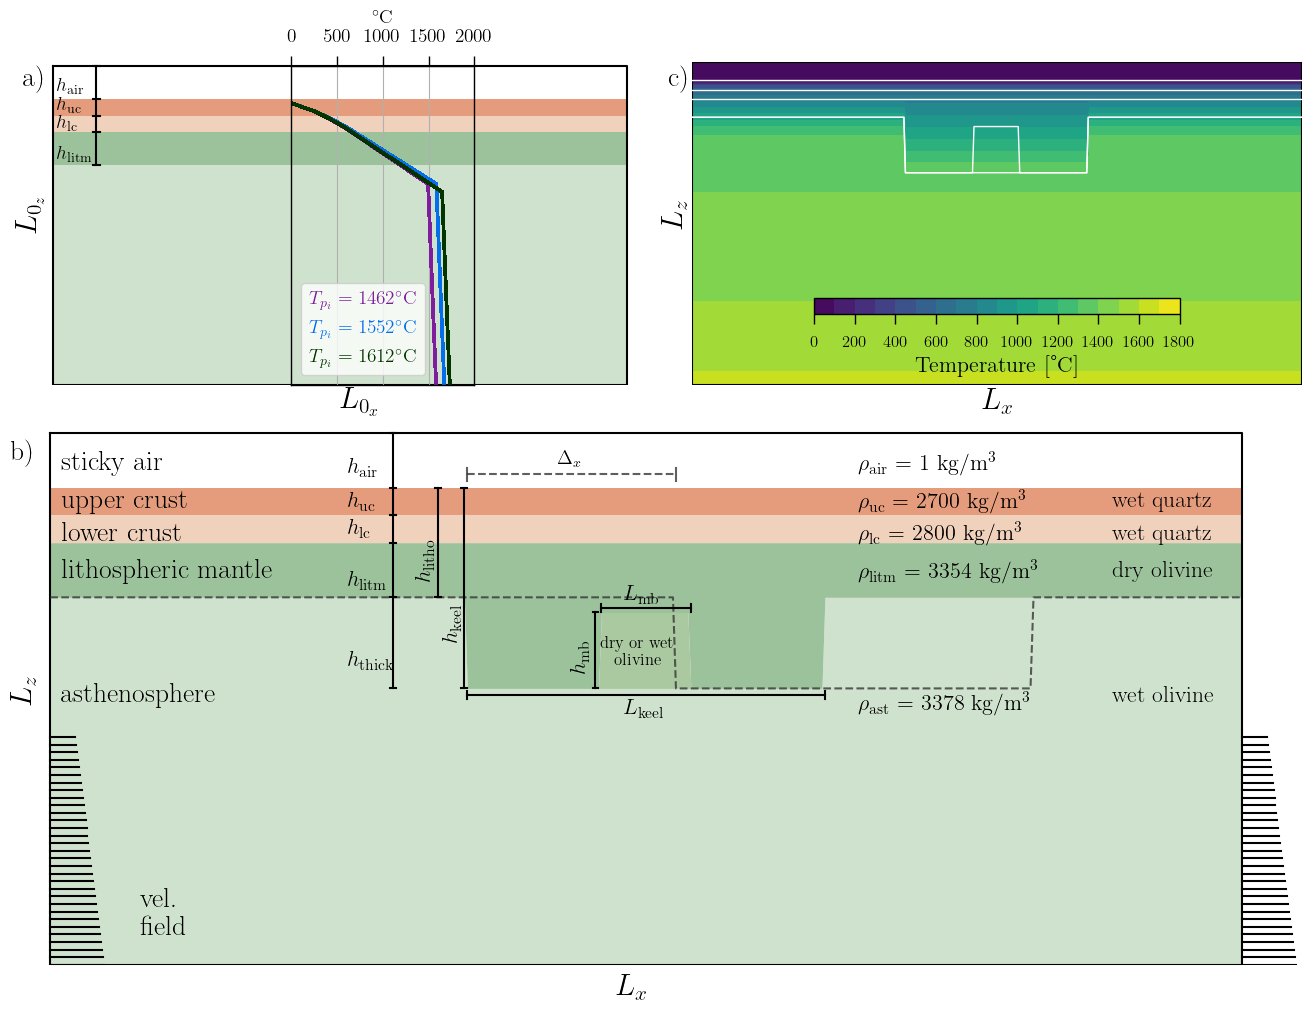

In [11]:
plt.close()
fig = plt.figure(figsize=(13,10), constrained_layout=True)
mosaic = """
         AACC
         BBBB
         """
axs = fig.subplot_mosaic(mosaic, gridspec_kw={'height_ratios':[0.3,0.5]})
fsize=16

#layers colour scheme
cr = 255.
color_uc = (228./cr,156./cr,124./cr)
color_lc = (240./cr,209./cr,188./cr)
color_lit = (155./cr,194./cr,155./cr)
color_ast = (207./cr,226./cr,205./cr)

##############################################################################
# Subplot a) Stability
##############################################################################
scale = 1.8
# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3*scale

thickness_lower_crust = 20.0e3*scale 

# thickness of upper crust (m)
thickness_upper_crust = 20.0e3*scale 

# total thickness of lithosphere (m)
thickness_litho = 80.0e3*scale #130 * 1.0e3

Lx_stab = 1600 * 1.0e3
Lz_stab = 700 * 1.0e3

Nx_stab = 161
Nz_stab = 71

x_stab = np.linspace(0, Lx_stab, Nx_stab)
z_stab = np.linspace(Lz_stab, 0, Nz_stab)
X_stab, Z_stab = np.meshgrid(x_stab, z_stab)
dz_stab = Lz_stab/ (Nz_stab - 1)

# Interfaces (bottom first)
interfaces_stab = {
    "litho_LAB": np.ones(Nx_stab) * (thickness_litho + thickness_sa), #lab horizontal
    "lower_crust": np.ones(Nx_stab) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx_stab) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx_stab) * (thickness_sa),
    }

axs['A'].text(-0.02, 0.95, 'a)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs['A'].transAxes)

axs['A'].set_xlim(0 - 50, Lx_stab/1000 + 50)
axs['A'].set_ylim(-Lz_stab/1000, 10)
axs['A'].axis('off')

#box domain contour
axs['A'].plot([0,0,Lx_stab/1000,Lx_stab/1000,0],[0,-Lz_stab/1000,-Lz_stab/1000,0,0],"k")

#paint layers
a1_stab = interfaces_stab["litho_LAB"]
a2_stab = a1_stab*0+700.0E3

axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_ast,ec="face",lw=0.0)

a2_stab = np.copy(a1_stab)
a1_stab = interfaces_stab["lower_crust"]
axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_lit,ec="face",lw=0.0)

a2_stab = np.copy(a1_stab)
a1_stab = interfaces_stab["upper_crust"]
axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_lc,ec="face",lw=0.0)

a2_stab = np.copy(a1_stab)
a1_stab= interfaces_stab["air"]
axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_uc,ec="face",lw=0.0)

xpos = 120
axs['A'].plot([xpos, xpos], [-0*scale,-120*scale], "k") #vertical bar
axs['A'].plot([xpos-10, xpos+10], [0*scale, 0*scale], "k") #upper horizontal bar
axs['A'].plot([xpos-10, xpos+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs['A'].plot([xpos-10, xpos+10], [-60*scale, -60*scale], "k") #base of upper crust
axs['A'].plot([xpos-10, xpos+10], [-80*scale, -80*scale], "k") #base of lower crust
axs['A'].plot([xpos-10, xpos+10], [-120*scale, -120*scale], "k") #base of litho
axs['A'].text(xpos-110, -30*scale, r"$h_{\mathrm{air}}$", fontsize=fsize-2)
axs['A'].text(xpos-110, -54*scale, r"$h_{\mathrm{uc}}$", fontsize=fsize-2)
axs['A'].text(xpos-110, -74*scale, r"$h_{\mathrm{lc}}$", fontsize=fsize-2)
axs['A'].text(xpos-110, -112*scale, r"$h_{\mathrm{litm}}$", fontsize=fsize-2)

#Lz and Lx
axs['A'].text(-105, -350, r"$L_{0_z}$",rotation=90, fontsize=fsize+6)
axs['A'].text(Lx_stab/2.0e3, -Lz_stab/1000-50, r"$L_{0_x}$", fontsize=fsize+6)

# ##############################################################################
# # Inset - Thermal profiles
# ##############################################################################
label_size=18
plt.rc('xtick', labelsize=label_size)
plt.rc('ytick', labelsize=label_size)

ax_aux = axs['A'].inset_axes([0.42,
                              0.001,
                              0.30,
                              0.985])

ax_aux.get_yaxis().set_visible(False)
ax_aux.set_xlabel('$^{\circ}$C', fontsize=label_size-4)
ax_aux.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, labelsize=label_size-4)
ax_aux.xaxis.set_label_position('top')
ax_aux.set_facecolor("none")
ax_aux.xaxis.grid('-k', alpha=1)

ax_aux.set_xlim([0,2000])
ax_aux.set_xticks([0, 500, 1000, 1500, 2000])
ax_aux.set_ylim(-Lz/1000, 10)

z = np.linspace(Lz, 0, Nz)*scale
cT = z>=40.0e3*scale

colors = ['xkcd:purple', 'xkcd:cerulean blue', 'xkcd:dark green']#, 'xkcd:orange', 'xkcd:scarlet']
lines = ['-', '-', '-']

for Tz, color, line in zip(Tzs, colors, lines):
    ax_aux.plot(Tz[cT], -(z[cT]/1000), line, color=color, linewidth=2, alpha=0.8)

axt = ax_aux.twinx()
axt1 = ax_aux.twinx()
axt.axis('off')
axt1.axis('off')

axt.plot([-10, -10], [-10, -10], '-k', label='CLS')
# axt.legend(loc='center left', handlelength=1.5, handletextpad=0.5, fontsize=14)

# axt1.plot([-10, -10], '-', color='xkcd:purple', label=r'$\Delta T = 0^{\circ}$C')
# axt1.plot([-10, -10], '-', color='xkcd:cerulean blue', label=r'$\Delta T = 100^{\circ}$C')
# axt1.plot([-10, -10], '-', color='xkcd:dark green', label=r'$\Delta T = 200^{\circ}$C')

# axt1.plot([-10, -10], '-', color='xkcd:purple', label=r'$\Delta T = 200^{\circ}$C')
# axt1.plot([-10, -10], '-', color='xkcd:cerulean blue', label=r'$\Delta T = 290^{\circ}$C')
# axt1.plot([-10, -10], '-', color='xkcd:dark green', label=r'$\Delta T = 350^{\circ}$C')

axt1.plot([-10, -10], '-', color='xkcd:purple', label=r'$T_{p_i} = 1462^{\circ}$C')
axt1.plot([-10, -10], '-', color='xkcd:cerulean blue', label=r'$T_{p_i} = 1552^{\circ}$C')
axt1.plot([-10, -10], '-', color='xkcd:dark green', label=r'$T_{p_i} = 1612^{\circ}$C')

axt1.legend(loc='lower left', labelcolor='linecolor', handlelength=0, handletextpad=0, fontsize=14)


##############################################################################
# Subplot b) interfaces,  Layers, veloc field
##############################################################################

scale = 1.8
# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3*scale

thickness_lower_crust = 20.0e3*scale 

# thickness of upper crust (m)
thickness_upper_crust = 20.0e3*scale 

# total thickness of lithosphere (m)
thickness_litho = 80.0e3*scale #130 * 1.0e3

interfaces = {
    "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
    "litho_HETERO": np.ones(Nx) * (thickness_litho + thickness_sa), #interface entre central e lateral -  interface 
    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx) * (thickness_sa),
    }

#Building craton
dx = Lx/(Nx-1)
# Lcraton = 600.0e3 #m
Lcraton = 1200.0e3 #m
#     Lcraton = 2000.0e3 #m
thickening = thickness_litho + 120.e3 #m
shift_craton = 0.0e3 #m

Ncraton = int(Lcraton//dx) #largura em indices

Nshift = int(shift_craton//dx)

interfaces['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

#Building mobile belt
interfaces['litho_HETERO'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening
Lmb = 300.0e3 #length of mobile belt
N_Lmb = int(Lmb//dx)
# thinning = 50.0e3
thinning = 100.0e3

interfaces['litho_HETERO'][Nx//2 - N_Lmb//2 + Nshift : Nx//2 + N_Lmb//2 + Nshift] = thickness_sa + thickening - thinning

############################################################################################################################
#interfaces with shift craton of 700 km
############################################################################################################################

# Interfaces (bottom first)
interfaces_sc = {
    "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx) * (thickness_sa),
    }

#Building craton
dx = Lx/(Nx-1)
Lcraton = 1200.0e3 #m
thickening = thickness_litho + 120.e3 #m
shift_craton = 700.0e3 #m

Ncraton = int(Lcraton//dx) #largura em indices

Nshift = int(shift_craton//dx)

interfaces_sc['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

# axs['B'].text(-120, 12, r"a)", size=20)
axs['B'].text(-0.02, 0.95, 'b)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs['B'].transAxes)

axs['B'].set_xlim(0 - 50, Lx/1000 + 200)
axs['B'].set_ylim(-Lz/1000, 10)
axs['B'].axis('off')

#box domain contour
axs['B'].plot([0,0,Lx/1000,Lx/1000,0],[0,-Lz/1000,-Lz/1000,0,0],"k")

#paint layers
a1 = interfaces["litho_LAB"]
a2 = a1*0 + Lz
axs['B'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_ast,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["litho_HETERO"]
axs['B'].fill_between(x/1000,-a1/1000,-a2/1000,fc='xkcd:dull green',ec="face",lw=0.0, alpha=0.6) #grey green

a2 = np.copy(a1)
a1 = interfaces["lower_crust"]
axs['B'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lit,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["upper_crust"]
axs['B'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lc,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["air"]
axs['B'].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_uc,ec="face",lw=0.0)

axs['B'].plot(x/1.0e3, -interfaces_sc["litho_LAB"]/1.0e3, '--', color='xkcd:dark grey', alpha=0.8)

#Length of shift craton
xpos_sc = Lx/2.0e3 - Lcraton/2.0e3 #1850 km
axs['B'].plot([xpos_sc, xpos_sc],
              [(-30+5)*scale,(-30-5)*scale],
              color='xkcd:dark grey', alpha=0.8) #vertical bar

axs['B'].plot([xpos_sc, xpos_sc+shift_craton/1.0e3],
              [-30*scale,-30*scale],
              "--", color='xkcd:dark grey', alpha=0.8) #horizontal bar

axs['B'].plot([xpos_sc+shift_craton/1.0e3, xpos_sc+shift_craton/1.0e3],
              [(-30+5)*scale,(-30-5)*scale],
              color='xkcd:dark grey', alpha=0.8) #vertical bar

axs['B'].text(Lx/2.0e3-shift_craton/2.0e3+50, -22*scale, r"$\Delta_x$", fontsize=fsize-2, rotation=0)

#Naming layers
fsize=20
axs['B'].text(0.02, 0.93, "sticky air", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.02, 0.86, "upper crust", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.02, 0.80, "lower crust", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.02, 0.73, "lithospheric mantle", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.02, 0.50, "asthenosphere", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)

#Rheology
fsize=17
axs['B'].text(0.85, 0.86, 'wet quartz', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.85, 0.80, 'wet quartz', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.85, 0.73, 'dry olivine', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.85, 0.50, 'wet olivine', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)

axs['B'].text(0.475, 0.58, 'dry or wet\nolivine', color='k', fontsize=fsize-5,
              horizontalalignment='center', verticalalignment='center',
              transform=axs['B'].transAxes)

#Layers densities
fsize=16
axs['B'].text(0.65, 0.93, r'$\rho_{\mathrm{air}}$ = 1 kg/m$^3$', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.65, 0.86, r'$\rho_{\mathrm{uc}}$ = 2700 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.65, 0.80, r'$\rho_{\mathrm{lc}}$ = 2800 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.65, 0.73, r'$\rho_{\mathrm{litm}}$ = 3354 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)
axs['B'].text(0.65, 0.485, r'$\rho_{\mathrm{ast}}$ = 3378 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs['B'].transAxes)


#thickness of cratonic region
fsize=16
xpos = 1390
axs['B'].plot([xpos-10, xpos+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs['B'].plot([xpos, xpos], [-40*scale,-335], "k") #vertical bar
axs['B'].plot([xpos-10, xpos+10], [-335, -335], "k") #lower horizontal bar
axs['B'].text(xpos-75, -150*scale, r"$h_{\mathrm{keel}}$", fontsize=fsize, rotation=90)

#thickness of non-cratonic region
xpos2 = 1300    
axs['B'].plot([xpos2-10, xpos2+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs['B'].plot([xpos2, xpos2], [-40*scale,-120*scale], "k") #vertical bar
axs['B'].plot([xpos2-10, xpos2+10], [-120*scale, -120*scale], "k") #lower horizontal bar
axs['B'].text(xpos2-75, -105*scale, r"$h_{\mathrm{litho}}$", fontsize=fsize, rotation=90)

#thickness of non-cratonic region
xpos3 = 1150
axs['B'].plot([xpos3, xpos3], [-0*scale,-335], "k") #vertical bar
axs['B'].plot([xpos3-10, xpos3+10], [0*scale, 0*scale], "k") #upper horizontal bar
axs['B'].plot([xpos3-10, xpos3+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs['B'].plot([xpos3-10, xpos3+10], [-60*scale, -60*scale], "k") #base of upper crust
axs['B'].plot([xpos3-10, xpos3+10], [-80*scale, -80*scale], "k") #base of lower crust
axs['B'].plot([xpos3-10, xpos3+10], [-120*scale, -120*scale], "k") #base of litho
axs['B'].plot([xpos3-10, xpos3+10], [-335, -335], "k") #lower horizontal bar

#Length of Cratonic Region
xpos4 = Lx/2.0e3 - Lcraton/2.0e3 #1850 km
axs['B'].plot([xpos4, xpos4], [(-345+5),(-345-5)], "k") #vertical bar
axs['B'].plot([xpos4, xpos4+Lcraton/1.0e3], [-345,-345], "k") #horizontal bar
axs['B'].plot([xpos4+Lcraton/1.0e3, xpos4+Lcraton/1.0e3], [(-345+5),(-345-5)], "k") #vertical bar
axs['B'].text(Lx/2.0e3-75, -370, r"$L_{\mathrm{keel}}$", fontsize=fsize, rotation=0)

axs['B'].text(xpos-390, -30*scale, r"$h_{\mathrm{air}}$", fontsize=fsize)
axs['B'].text(xpos-390, -54*scale, r"$h_{\mathrm{uc}}$", fontsize=fsize)
axs['B'].text(xpos-390, -74*scale, r"$h_{\mathrm{lc}}$", fontsize=fsize)
axs['B'].text(xpos-390, -112*scale, r"$h_{\mathrm{litm}}$", fontsize=fsize)
axs['B'].text(xpos-390, -170*scale, r"$h_{\mathrm{thick}}$", fontsize=fsize)

#Mobile Belt
xpos4 = Lx/2.0e3 - Lmb/2.0e3 #1850 km
axs['B'].plot([xpos4-10- 20, xpos4+10- 20], [-235, -235], "k") #lower horizontal bar
axs['B'].plot([xpos4- 20, xpos4- 20], [-235,-335], "k") #vertical bar
axs['B'].plot([xpos4-10- 20, xpos4+10- 20], [-335, -335], "k") #lower horizontal bar
axs['B'].text(xpos4-85- 20, -310, r"$h_{\mathrm{mb}}$", fontsize=fsize, rotation=90)

axs['B'].plot([xpos4, xpos4], [(-230+5),(-230-5)], "k") #vertical bar
axs['B'].plot([xpos4, xpos4+Lmb/1.0e3], [-230,-230], "k") #horizontal bar
axs['B'].plot([xpos4+Lmb/1.0e3, xpos4+Lmb/1.0e3], [-230+5,-230-5], "k") #vertical bar
axs['B'].text(Lx/2.0e3-75, -220, r"$L_{\mathrm{mb}}$", fontsize=fsize, rotation=0)

#Lz and Lx
fsize=22
axs['B'].text(-135, -350, r"$L_z$",rotation=90, fontsize=fsize)
axs['B'].text(Lx/1000/2-100, -Lz/1000-40, r"$L_x$", fontsize=fsize)

axs['B'].text(300,-660,"vel.\nfield",fontsize=fsize-2)

z = np.linspace(Lz, 0, Nz)
scale_veloc = 15000*365.*24.*3600.
for i in range(0,np.size(z)-40,1):
    if VX[i,0]!=0.0:
        axs['B'].plot([scale_veloc*VX[i, 0],0], [-z[i]/1000,-z[i]/1000],"k")

for i in range(0,np.size(z)-40,1):
    axs['B'].plot([scale_veloc*VX[i, -1]+Lx/1000,Lx/1000], [-z[i]/1000,-z[i]/1000],"k")

##############################################################################
# Subplot c) Thermal profiles of keel scenarios
##############################################################################
scale = 1.0
# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3*scale

thickness_lower_crust = 20.0e3*scale 

# thickness of upper crust (m)
thickness_upper_crust = 20.0e3*scale 

# total thickness of lithosphere (m)
thickness_litho = 80.0e3*scale #130 * 1.0e3

interfaces = {
    "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
    "litho_HETERO": np.ones(Nx) * (thickness_litho + thickness_sa), #interface entre central e lateral -  interface 
    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx) * (thickness_sa),
    }

#Building craton
dx = Lx/(Nx-1)
# Lcraton = 600.0e3 #m
Lcraton = 1200.0e3 #m
#     Lcraton = 2000.0e3 #m
thickening = thickness_litho + 120.e3 #m
shift_craton = 0.0e3 #m

Ncraton = int(Lcraton//dx) #largura em indices

Nshift = int(shift_craton//dx)

interfaces['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

#Building mobile belt
interfaces['litho_HETERO'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening
Lmb = 300.0e3 #length of mobile belt
N_Lmb = int(Lmb//dx)
# thinning = 50.0e3
thinning = 100.0e3

interfaces['litho_HETERO'][Nx//2 - N_Lmb//2 + Nshift : Nx//2 + N_Lmb//2 + Nshift] = thickness_sa + thickening - thinning

axs['C'].text(-0.04, 0.95, 'c)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs['C'].transAxes)

axs['C'].set_xlim(0 - 50, Lx/1000 + 50)
axs['C'].set_ylim(-Lz/1000, 10)
axs['C'].axis('off')

#box domain contour
axs['C'].plot([0,0,Lx/1000,Lx/1000,0],[0,-Lz/1000,-Lz/1000,0,0],"k")

filename = 'input_temperature_0_keel.txt'
temper_0 = np.loadtxt(filename, skiprows=4, unpack=True)
temper_0 = np.reshape(temper_0, (Nz, Nx))

im = axs['C'].contourf(X/1.0e3, -Z/1.0e3, temper_0, cmap='viridis', levels=np.arange(0, np.max(temper_0) + 100, 100))
for interface in interfaces:
    if(interface != 'litho_HETERO'):
        axs['C'].plot(x/1.0e3, -interfaces[interface]/1.0e3/scale, '-', color='xkcd:white', lw=1.0)
    else:
        axs['C'].plot(x/1.0e3, -interfaces[interface]/1.0e3/scale, '-', color='xkcd:white', lw=1.0)

axins1 = inset_axes(axs['C'],
                    loc='lower center',
                    width="100%",  # respective to parent_bbox width
                    height="100%",  # respective to parent_bbox width
                    bbox_to_anchor=(0.20,#horizontal position respective to parent_bbox or "loc" position
                                    0.19,# vertical position
                                    0.6,# width
                                    0.05),# height
                    bbox_transform=axs['C'].transAxes
                    )

clb = fig.colorbar(im,
                    cax=axins1,
                    orientation='horizontal',
                    fraction=0.08,
                    pad=0.2)

fsize = 16
clb.set_label("Temperature [°C]", fontsize=fsize)
clb.ax.tick_params(labelsize=12)

axs['C'].set_xlim(0, Lx/1000)
axs['C'].set_ylim(-Lz/1000, 0)

fsize = 22
axs['C'].text(-200, -350, r"$L_z$",rotation=90, fontsize=fsize)
axs['C'].text(Lx/1000/2-100, -Lz/1000-50, r"$L_x$", fontsize=fsize)

# Saving figure
fig.savefig('out/' + "NumSetup_Keel.pdf", dpi=400, bbox_inches='tight')
fig.savefig('out/' + "NumSetup_Keel.png", dpi=400, bbox_inches='tight')